# 📖 Background

You are a data analyst at an environmental company. Your task is to evaluate ozone pollution across various regions.

You’ve obtained data from the U.S. Environmental Protection Agency (EPA), containing daily ozone measurements at monitoring stations across California. However, like many real-world datasets, it’s far from clean: there are missing values, inconsistent formats, potential duplicates, and outliers.

Before you can provide meaningful insights, you must clean and validate the data. Only then can you analyze it to uncover trends, identify high-risk regions, and assess where policy interventions are most urgently needed.

# ✅Executive Summary of Recommendations

Ozone pollution remains a serious public health issue across California. This investigation analyzed statewide EPA monitoring data from 2024 to identify trends, possible causes and areas for targeted action. 

**Key Findings**
- Counties in the southern and inland-central regions (e.g Riverside and San Bernardino) experience the most consistent and prolonged periods of high ozone. Residents in these areas were at risk of chronic exposure with weekly averages exceeding the EPA's 0.070 ppm standard.<br><br>

- In majority of the counties, ozone levels rise predictably during the summer and are at the lowest concentrations during the winter.<br><br>

- No significant difference was found in ozone levels between weekdays and weekends at the statewide level. This suggests that typical urban patterns alone do not explain high ozone events.<br><br>

- While differences in ozone readings were observed across measurement methods, these were likely due to their geographic deployment rather than intrinsic bias in the methods themselves.<br><br>

**Based on the findings above, the team recommends the following actions:**

1.  Step up air quality warnings during the late spring and summer months when the risk of high ozone is greatest. And since the day of the week has minimal effect on ozone, focus public guidance on broader seasonal and weather-related risk factors<br><br>
2.  Direct resources and public health outreach toward counties in the South and Central regions (particularly in counties like San Bernadino), where high ozone days are most frequent.<br><br>
3.  Address data gaps in counties with incomplete records to make sure the annual evidence is comprehensive across the entire state.<br><br>
4.  Encourage use of multiple measurement methods at monitoring stations to allow for clearer ozone reading comparisons.<br><br>
5.  Factor in the effects of large-scale environmental events like wildfires when planning responses because these events can create spikes in ozone levels far beyond local sources.<br><br>
6.  Fund studies into why some counties (e.g., San Francisco and Alameda) experience unusual trends and low summer ozone, to inform best practices for urban air quality management.<br><br>
7.  Monitor evolving patterns as urban development and population changes.


# 🗂️ Case Briefing

**Case File:** CAL-O3-2024

**Description:** Ozone Concentration Analysis in the State of California

**Department:** Environmental Impact Division

**Priority level:** High

At the request of the Environmental Impact Division, our data analytics unit was dispatched to investigate a growing concern in California. Reports of rising ozone pollution had triggered concern and our team was called in to uncover the facts. 

On March 1st, 2025, we received the official data from the U.S. Environmental Protection Agency containing daily ozone readings from monitoring stations across the state. At the outset, the team gathered to decide which questions the investigation would focus on. We expected a straightforward process, but those expectations changed as soon as we examined the case file. The data showed several issues that made immediate analysis impossible. Instead, much of our early efforts had to be directed toward cleaning and preparing the evidence. Only after days of careful work was the dataset ready for analysis. From there, we were able to track ozone trends across California, identify locations with high ozone, and evaluate the impact of measurement methods and human activity.

This report details the full course of our investigation and its conclusive findings.


# 🔍 1. Data Exploration

The team began the investigation by preparing all the necessary tools and bringing the EPA dataset into our working environment.

In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import re
from datetime import timedelta
from scipy.stats import mannwhitneyu
import folium
from folium.plugins import HeatMap

ozone = pd.read_csv('data/ozone.csv')

Our first step was to understand the scope of the data. The file received from the EPA contained almost 55,000 daily ozone readings and 17 fields. Each row represented a daily record from one of California’s monitoring stations.

In [86]:
rows, cols = ozone.shape
print(f"Number of rows: {rows}")
print(f"Number of columns: {cols}")

Number of rows: 54759
Number of columns: 17


As we started to review the first records, we quickly noticed problems with the `Date` column. Some records showed dates as numbers, others with words, and many were incomplete. Even so, the order of the dates suggested they were meant to follow a continuous timeline. However, the inconsistent formats made it hard to rely on the information in its current state.

In [87]:
ozone.head()

,Date,Source,Site ID,POC,Daily Max 8-hour Ozone Concentration,Units,Daily AQI Value,Local Site Name,Daily Obs Count,Percent Complete,Method Code,CBSA Code,CBSA Name,County FIPS Code,County,Site Latitude,Site Longitude
0,/2024,AQS,60010007,1,0.031,ppm,29.0,Livermore,17,100.0,47.0,41860.0,"San Francisco-Oakland-Hayward, CA",1,Alameda,37.687526,-121.784217
1,01/02/2024,AQS,60010007,1,0.037,ppm,34.0,Livermore,17,100.0,47.0,41860.0,"San Francisco-Oakland-Hayward, CA",1,Alameda,37.687526,-121.784217
2,/2024,AQS,60010007,1,NaN,ppm,30.0,Livermore,17,100.0,47.0,41860.0,"San Francisco-Oakland-Hayward, CA",1,Alameda,37.687526,-121.784217
3,January 04/2024,AQS,60010007,1,0.026,ppm,24.0,Livermore,17,100.0,47.0,41860.0,"San Francisco-Oakland-Hayward, CA",1,Alameda,37.687526,-121.784217
4,January 05/2024,AQS,60010007,1,0.027,ppm,25.0,Livermore,17,100.0,47.0,41860.0,"San Francisco-Oakland-Hayward, CA",1,Alameda,37.687526,-121.784217


Looking at the tail end of the data confirmed our concerns. The sites and dates were out of order, with earlier months appearing after later ones. This broke the expected timeline and proved that the `Date` column needed more attention before it could be used in the analysis.

In [88]:
ozone.tail()

,Date,Source,Site ID,POC,Daily Max 8-hour Ozone Concentration,Units,Daily AQI Value,Local Site Name,Daily Obs Count,Percent Complete,Method Code,CBSA Code,CBSA Name,County FIPS Code,County,Site Latitude,Site Longitude
54754,02/16/2024,AQS,60710005,1,0.044,ppm,41.0,Crestline,17,100.0,87.0,40140.0,"Riverside-San Bernardino-Ontario, CA",71,San Bernardino,34.243100,-117.272350
54755,August 14/2024,AQS,60270101,1,0.057,ppm,58.0,Death Valley NP - Park Village,17,100.0,87.0,13860.0,"Bishop, CA",27,Inyo,36.508611,-116.847778
54756,June 30/2024,AQS,60690002,1,NaN,ppm,29.0,Hollister,17,100.0,47.0,41940.0,"San Jose-Sunnyvale-Santa Clara, CA",69,San Benito,36.843425,-121.362100
54757,/2024,AQS,61072010,1,0.058,ppm,61.0,Porterville,17,100.0,199.0,47300.0,"Visalia-Porterville, CA",107,Tulare,36.031831,-119.055018
54758,July 22/2024,AQS,60611004,1,NaN,ppm,45.0,Tahoe City-Fairway Drive,17,100.0,87.0,40900.0,"Sacramento--Roseville--Arden-Arcade, CA",61,Placer,39.166017,-120.148833


Given the size of the dataset, manual inspection of every row was not feasible. Instead, we drew a random sample to better understand the data. This uncovered additional issues, including inconsistent decimal places in the `Site Latitude` and `Site Longitude` fields which could complicate location-based analysis later on.

In [89]:
ozone.sample(5, random_state=75)

,Date,Source,Site ID,POC,Daily Max 8-hour Ozone Concentration,Units,Daily AQI Value,Local Site Name,Daily Obs Count,Percent Complete,Method Code,CBSA Code,CBSA Name,County FIPS Code,County,Site Latitude,Site Longitude
3488,/2024,AirNow,60131002,1,0.038,ppm,35.0,Bethel Island,24,100.0,NaN,41860.0,"San Francisco-Oakland-Hayward, CA",13,Contra Costa,38.006311,-121.641918
3758,08/30/2024,AirNow,60131004,1,0.035,ppm,32.0,San Pablo,24,100.0,NaN,41860.0,"San Francisco-Oakland-Hayward, CA",13,Contra Costa,37.960400,-122.356811
43852,02/29/2024,AQS,60833001,1,0.038,ppm,35.0,Santa Ynez,17,100.0,87.0,42200.0,"Santa Maria-Santa Barbara, CA",83,Santa Barbara,34.605819,-120.075069
1935,September 05/2024,AQS,60070008,1,NaN,ppm,51.0,Chico-East Avenue,17,100.0,87.0,17020.0,"Chico, CA",7,Butte,39.761680,-121.840470
28100,/2024,AQS,60659001,1,0.065,ppm,84.0,Lake Elsinore,17,100.0,87.0,40140.0,"Riverside-San Bernardino-Ontario, CA",65,Riverside,33.676490,-117.330980


To pinpoint where the main problems were, we ran a quick scan across all the columns. We discovered that some fields had missing values, including those that were key to our analysis. The `Date` column was also stored as an object data type, which was expected given the mixed formats we had already seen. We also found that the list of `County FISP Code` didn’t match the number of `County` names, even though neither column had any missing values. This suggested that the naming of counties was not consistent throughout the file.


In [90]:
ozone_profile = pd.DataFrame({
    "Data Type":ozone.dtypes,
    "Missing Count":ozone.isna().sum(),
    "Missing %": (ozone.isnull().mean() * 100).round(2),
    "Unique Count": ozone.nunique()
})

ozone_profile


,Data Type,Missing Count,Missing %,Unique Count
Date,object,0,0.00,733
Source,object,0,0.00,2
Site ID,int64,0,0.00,162
POC,int64,0,0.00,2
Daily Max 8-hour Ozone Concentration,float64,2738,5.00,124
Units,object,0,0.00,1
Daily AQI Value,float64,2738,5.00,120
Local Site Name,object,0,0.00,162
Daily Obs Count,int64,0,0.00,24
Percent Complete,float64,0,0.00,23


On the positive side, some parts of the data profile were solid. Most of the columns had the correct data type plus the number of unique `Site ID` matched up perfectly with the unique `Site Latitude`, `Site Longitude`, and `Local Site Name` fields. This meant that information tied to each monitoring location was reliable for cleaning and analysis. We also observed that the `Units` column only had one value throughout the dataset, so we didn’t have to worry about converting ozone measurements, and spotting outliers would be more straightforward.

In the final stage of our initial review, we examined the statistics for the numerical columns. Most values were within expected ranges, but the `Daily Obs Count` reached as high as 1,000, which seemed unusual. Otherwise, the `Site Latitude` and `Site Longitude` ranges confirmed that all sites were within California. No other major concerns were found in the output.

In [91]:
ozone.describe()

,Site ID,POC,Daily Max 8-hour Ozone Concentration,Daily AQI Value,Daily Obs Count,Percent Complete,Method Code,CBSA Code,County FIPS Code,Site Latitude,Site Longitude
count,5.475900e+04,54759.000000,52021.000000,52021.000000,54759.000000,54759.000000,48269.000000,52351.000000,54759.000000,54759.000000,54759.000000
mean,6.059086e+07,1.000256,0.043519,45.280079,27.534688,99.340346,89.051669,36107.577697,58.918406,36.169550,-119.665107
std,3.001943e+05,0.015988,0.014610,25.899065,97.800446,3.658452,36.636778,9536.717562,30.012874,2.192841,2.022987
min,6.001001e+07,1.000000,0.000000,0.000000,1.000000,6.000000,47.000000,12540.000000,1.000000,32.578165,-124.179490
25%,6.031100e+07,1.000000,0.034000,31.000000,17.000000,100.000000,87.000000,31080.000000,31.000000,34.181977,-121.420838
50%,6.065500e+07,1.000000,0.041000,38.000000,17.000000,100.000000,87.000000,40140.000000,65.000000,36.209286,-119.828400
75%,6.081100e+07,1.000000,0.052000,48.000000,17.000000,100.000000,87.000000,41860.000000,81.000000,37.961578,-118.068500
max,6.113100e+07,2.000000,0.139000,236.000000,1000.000000,100.000000,199.000000,49700.000000,113.000000,41.726892,-114.602090


# 🧼 2. Data Cleaning

With the scope of the case established, our attention turned to preparing the evidence for analysis. It became clear early on that the daily readings were not complete for all 162 monitoring sites. In a perfect scenario, each site would have supplied 366 readings for the year 2024, making a total of 59,292 records. Our dataset fell short of that mark. Contacting the EPA for a fresh copy was not an option as department protocols require that we work with the evidence as received.


To protect the integrity of the original data, we first created a working copy.

In [92]:
# Make a copy for cleaning
df = ozone.copy()

From there, the team divided the cleaning into four stages: 
1. Formatting and data type validation
2. Removing duplicates
3. Detecting outliers
4. Handling missing values

This order was intentional. Formatting came first because standardizing the data could help expose hidden duplicates. And dealing with outliers after missing values might skew the data, so imputation was best left until after unusual values have been reviewed.

## 2.1 Formatting and data type validation

Our main concern at this stage was the `Date` column. The timeline was the backbone of our investigation and distorting dates that were already in order could erase crucial evidence. To avoid this, we created an extra index for every record. This way, we could arrange the dataset so that all entries for a single site were grouped together, without mixing in records from other sites.  

In [93]:
# Add original index column
df['orig_index'] = df.index

# Sort so that for each Site ID, the original row order is preserved
df = df.sort_values(['Site ID', 'orig_index']).reset_index(drop=True)

# Drop the helper index column 
df = df.drop(columns='orig_index')

By first sorting by `Site ID` and then by the new index, we preserved the original sequence of readings for each site. 

We can see this effect if we compare the tail sections of our original and current datasets

In [94]:
print('BEFORE\n')
print(ozone[['Date', 'Site ID']].tail())

BEFORE

                 Date   Site ID
54754      02/16/2024  60710005
54755  August 14/2024  60270101
54756    June 30/2024  60690002
54757           /2024  61072010
54758    July 22/2024  60611004


In [95]:
print('AFTER\n')
print(df[['Date', 'Site ID']].tail())

AFTER

                   Date   Site ID
54754  December 29/2024  61131003
54755  December 30/2024  61131003
54756        12/31/2024  61131003
54757        10/10/2024  61131003
54758             /2024  61131003


Next, the team addressed standardization of all object-type fields including the `Date` column. We stripped trailing spaces and converted text to title case. 

In [96]:
# Strip spaces and apply title case for each string column
string_cols = df.select_dtypes(include=['object']).columns

for col in string_cols:
    df[col] = df[col].str.strip().str.title()

### 2.1.1 The `Date` Column

Our attention then returned to the date values themselves. We wanted to filter out all incomplete dates like '/2024' and have only one format for compelete dates. To do this, we split every date into three parts: day, month, and year. Any date that did not fit this rule was turned to a `null` value. All returned values from this process were put in a new column `Date Parsed`. 

In [97]:
# Checks if a date string can be split cleanly into three parts 
def has_three_parts(date_string):
    date_string = str(date_string)
    
    raw_parts = re.split(r'[-/\s]+', date_string) # Split on dash, slash, or whitespace
   
    clean_parts = []
    for part in raw_parts:
        if part:
            clean_parts.append(part)
    return len(clean_parts) == 3
    
# Parses a date string into a datetime object only if it has three parts; otherwise returns NaT 
def custom_parse(date_string):
    if has_three_parts(date_string):
        return pd.to_datetime(date_string, errors='coerce')
    else:
        return pd.NaT

# Applies function to Date column and returns new column Date Parsed 
df['Date Parsed'] = df['Date'].apply(custom_parse)

# Compare before and after
print(df[['Date', 'Date Parsed']].head())

              Date Date Parsed
0            /2024         NaT
1       01/02/2024  2024-01-02
2            /2024         NaT
3  January 04/2024  2024-01-04
4  January 05/2024  2024-01-05


We ended up with 9202 missing values in `Date Parsed` due to the many bad dates in the `Date` column that were converted to `null` values. But we ensured `Date Parsed` was of the `datetime` data type to help us impute the missing values at a later stage.

In [98]:
date_parsed_dtype = df['Date Parsed'].dtype
date_parsed_missing = df['Date Parsed'].isnull().sum()

print(f"Missing values in Date Parsed: {date_parsed_missing}")
print(f"\nDatatype of Date Parsed: {date_parsed_dtype}")

Missing values in Date Parsed: 9202

Datatype of Date Parsed: datetime64[ns]


A quick check of the cleaned `Date Parsed` column confirmed that our data spanned the entire calendar year. The earliest reading was from January 1, 2024, and the latest from December 31, 2024. This verified that, even with the gaps and null values, the timeline covered the required period

In [99]:
print(f"First Date: {df['Date Parsed'].min()}")
print(f"Last Date: {df['Date Parsed'].max()}")

First Date: 2024-01-01 00:00:00
Last Date: 2024-12-31 00:00:00


### 2.1.2 Matching `County` names to `County FIPS Code`

We then turned to the relationship between county names and their codes. Our data exploration earlier, showed that the number of county codes didn’t match the number of county names. On closer inspection, we discovered that shorthand forms like “La” and “Sf” had been used in addition to full names. 

In [100]:
n_codes = df['County FIPS Code'].nunique()
n_counties = df['County'].nunique()

print(f"=> Unique County FIPS Codes: {n_codes}")
print(f"=> Unique County Names: {n_counties}")

# Find FIPS codes with more than one county name variant and display the names
county_names = df.groupby('County FIPS Code')['County'].unique().reset_index(name='County Names')
problem_counties = county_names[county_names['County Names'].apply(len) > 1]

print("\nCounty FIPS codes with multiple county name variants:")
print(problem_counties)

=> Unique County FIPS Codes: 48
=> Unique County Names: 50

County FIPS codes with multiple county name variants:
    County FIPS Code         County Names
15                37    [Los Angeles, La]
30                75  [San Francisco, Sf]


Using a dictionary, we brought all county names in line with their proper forms. After this correction, the unique counts of county codes and county names matched to confirm consistency.

In [101]:
standardization_dict = {
    'La': 'Los Angeles',
    'Sf': 'San Francisco'
}

df['County Parsed'] = df['County'].apply(lambda x: standardization_dict.get(x, x))

n_codes = df['County FIPS Code'].nunique()
n_counties = df['County Parsed'].nunique()

print("After standardisizing:")
print(f"\n=> Unique County FIPS Codes: {n_codes}")
print(f"=> Unique County Names: {n_counties}")

After standardisizing:

=> Unique County FIPS Codes: 48
=> Unique County Names: 48


### 2.1.3 Rounding Off Decimals

All columns already had the appropriate data type so the final step of this stage was formatting fields of the `float` data type.

In [103]:
df['Site Latitude'] = df['Site Latitude'].round(5)
df['Site Longitude'] = df['Site Longitude'].round(5)
df['Daily Max 8-hour Ozone Concentration'] = df['Daily Max 8-hour Ozone Concentration'].round(3)

## 2.2 Removing Duplicates

With the dataset formatted, the next step was to address duplicates. The team first agreed on what counted as a duplicate for this case. In this dataset, each row should be a unique reading based on the combination of `Date Parsed `and `Site ID`. If two entries had the same date and site, they represented the same reading recorded more than once and were considered duplicates.

However, complications arose due to missing values in `Date Parsed`. During formatting, incomplete dates such as ‘/2024’ were converted to `NaT` or missing value. This meant that for some records, we could no longer tell if this missing date originally represented a unique day for that site or if it was a duplicate.

To handle this, we split the duplication handling into two stages. First, we targeted records with valid dates and deferred any cases with missing dates until after those values could be imputed.

Focusing on the subset with valid dates, we found 670 duplicate entries which included the first instances. 

In [104]:
# Find all duplicates (including original) where Date Parsed is not null
mask_valid_date = df['Date Parsed'].notna()
dupe_mask = df[mask_valid_date].duplicated(subset=['Site ID', 'Date Parsed'], keep=False)
all_dupes = df[mask_valid_date][dupe_mask]

print(f"Total duplicates (including originals) with valid dates: {dupe_mask.sum()}")

# View a sorted sample of these duplicates
sample_dupes = all_dupes.sort_values(['Site ID', 'Date Parsed'])

sample_dupes[['Date Parsed', 'Site ID', 'Daily Max 8-hour Ozone Concentration']].tail(10)

Total duplicates (including originals) with valid dates: 670


,Date Parsed,Site ID,Daily Max 8-hour Ozone Concentration
53438,2024-05-14,61112002,0.051
53669,2024-05-14,61112002,0.051
53830,2024-06-06,61113001,0.040
54038,2024-06-06,61113001,NaN
53913,2024-08-29,61113001,0.043
54037,2024-08-29,61113001,0.043
54275,2024-09-06,61130004,0.053
54393,2024-09-06,61130004,0.053
54674,2024-10-10,61131003,0.043
54757,2024-10-10,61131003,0.043


To decide which record to keep when duplicates appeared, the team focused on data quality. We looked at three important columns which had a lot of missing values:`Daily Max 8-hour Ozone Concentration`, `Daily AQI Value`, and `Method Code`. 

Within each group of duplicates, we kept the record with the fewest missing values across these columns. This ensured we preserved the most complete information for each site and date.

In [105]:
# Define your important columns for scoring
important_cols = ['Daily Max 8-hour Ozone Concentration', 'Daily AQI Value', 'Method Code']

# Calculate missing values for important columns (lower is better)
df.loc[mask_valid_date, 'missing_count'] = df.loc[mask_valid_date, important_cols].isnull().sum(axis=1)

 # Sort so the row with least missing data comes first in each group
df.loc[mask_valid_date, :] = df.loc[mask_valid_date].sort_values(['Site ID', 'Date Parsed', 'missing_count'])
dupe_to_drop = df.loc[mask_valid_date].duplicated(subset=['Site ID', 'Date Parsed'], keep='first')

# Drop duplicates, keeping the "best" (now first) row
df.drop(df.loc[mask_valid_date].index[dupe_to_drop], inplace=True)

# Clean
df.drop(columns=['missing_count'], inplace=True)
df.reset_index(drop=True, inplace=True)

# Confirm that no duplicates with valid dates remained
dupe_mask_post = df[df['Date Parsed'].notna()].duplicated(subset=['Site ID', 'Date Parsed'], keep=False)
print(f"Duplicates remaining after dropping: {dupe_mask_post.sum()}")

Duplicates remaining after dropping: 0


After removing lower-quality duplicates, the dataset was reduced to **54, 424** rows.

In [106]:
print(f"Current number of rows in dataset: {len(df)}")

Current number of rows in dataset: 54424


## 2.3 Detecting Outliers

After handling duplicates, our data cleaning process moved to finding outliers and invalids. Our goal here was to separate the unusual from the unusable.

During the exploration phase, we scanned for columns that could have obviously impossible records such as location values outside California, dates future dates or percentages that did not make sense. Fortunately, no such errors occurred and that cut down on the work we needed to do during this stage.

### 2.3.1 The `Daily Max 8-hour Ozone Concentration` and `Daily AQI Value` Columns

So, we went straight to examining the key measurement fields: `Daily Max 8-hour Ozone Concentration` and the `Daily AQI Value`. We discovered the two were directly proportional and one could be derived from the other. 

A quick look at the boxplots for both fields showed a large number of outliers, which was concerning at first. 

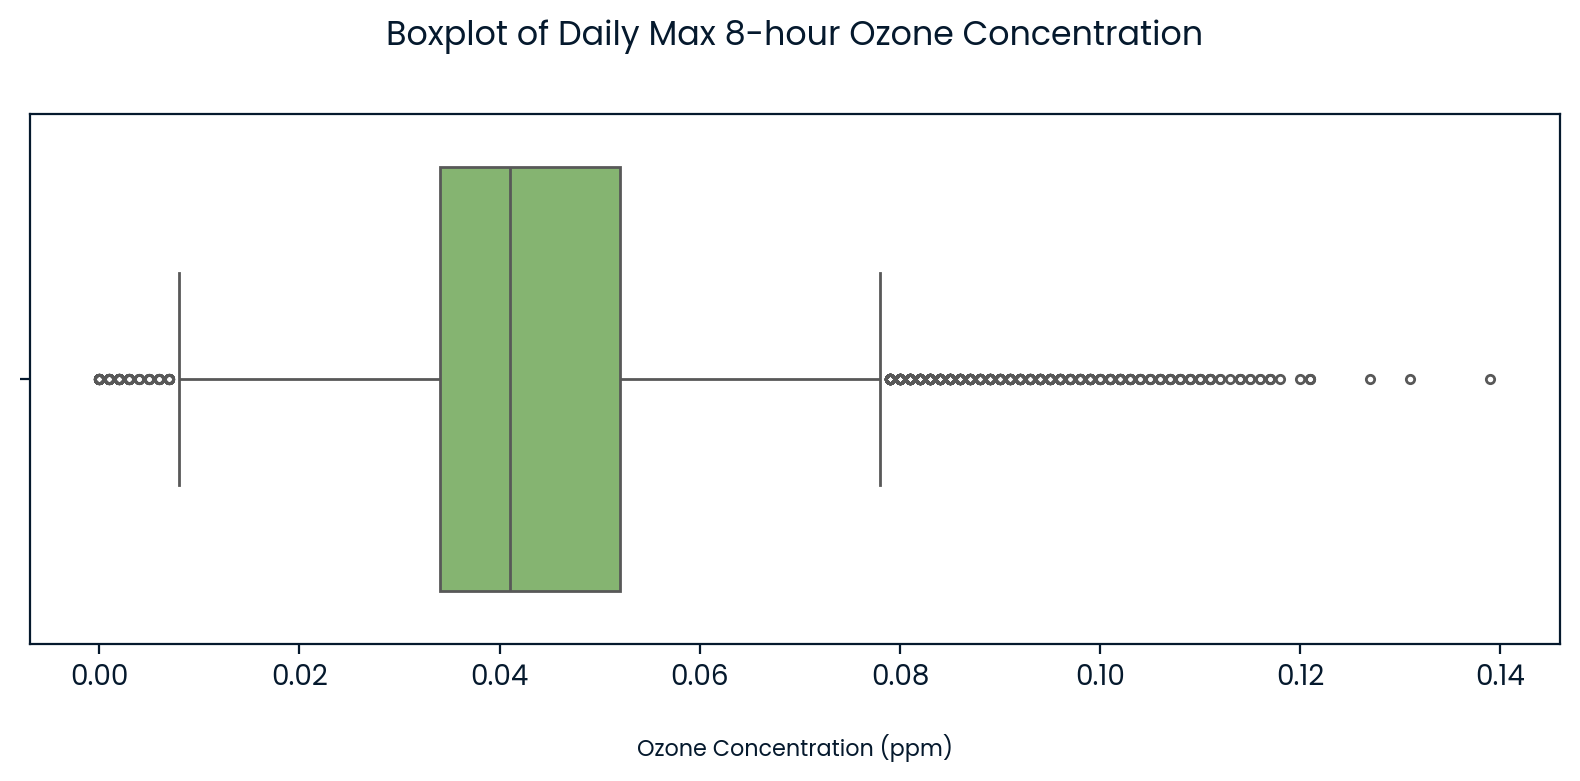

In [107]:
plt.figure(figsize=(8, 4))
sns.boxplot(
    x=df['Daily Max 8-hour Ozone Concentration'],
    palette='summer',
    flierprops=dict(markersize=3),    
)
plt.title("Boxplot of Daily Max 8-hour Ozone Concentration", pad=25)
plt.xlabel("Ozone Concentration (ppm)", fontsize=8, labelpad=15)
plt.tight_layout()
plt.show()


In [108]:
# Calculate Q1 and Q3
Q1 = df['Daily Max 8-hour Ozone Concentration'].quantile(0.25)
Q3 = df['Daily Max 8-hour Ozone Concentration'].quantile(0.75)

# Calculate IQR
IQR = Q3 - Q1

# Calculate bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"Q1 = {Q1:.3f} | Q3 = {Q3:.3f} | IQR = {IQR:.3f}")
print(f"\nLower bound: {lower_bound:.3f}")
print(f"Upper bound: {upper_bound:.3f}")

# Identify outliers
outliers = df[
    (df['Daily Max 8-hour Ozone Concentration'] < lower_bound) | (df['Daily Max 8-hour Ozone Concentration'] > upper_bound)
]

print(f"\nNumber of outliers: {len(outliers)}")
print(f"Max Ozone Concentration: {df['Daily Max 8-hour Ozone Concentration'].max()}")

Q1 = 0.034 | Q3 = 0.052 | IQR = 0.018

Lower bound: 0.007
Upper bound: 0.079

Number of outliers: 1232
Max Ozone Concentration: 0.139


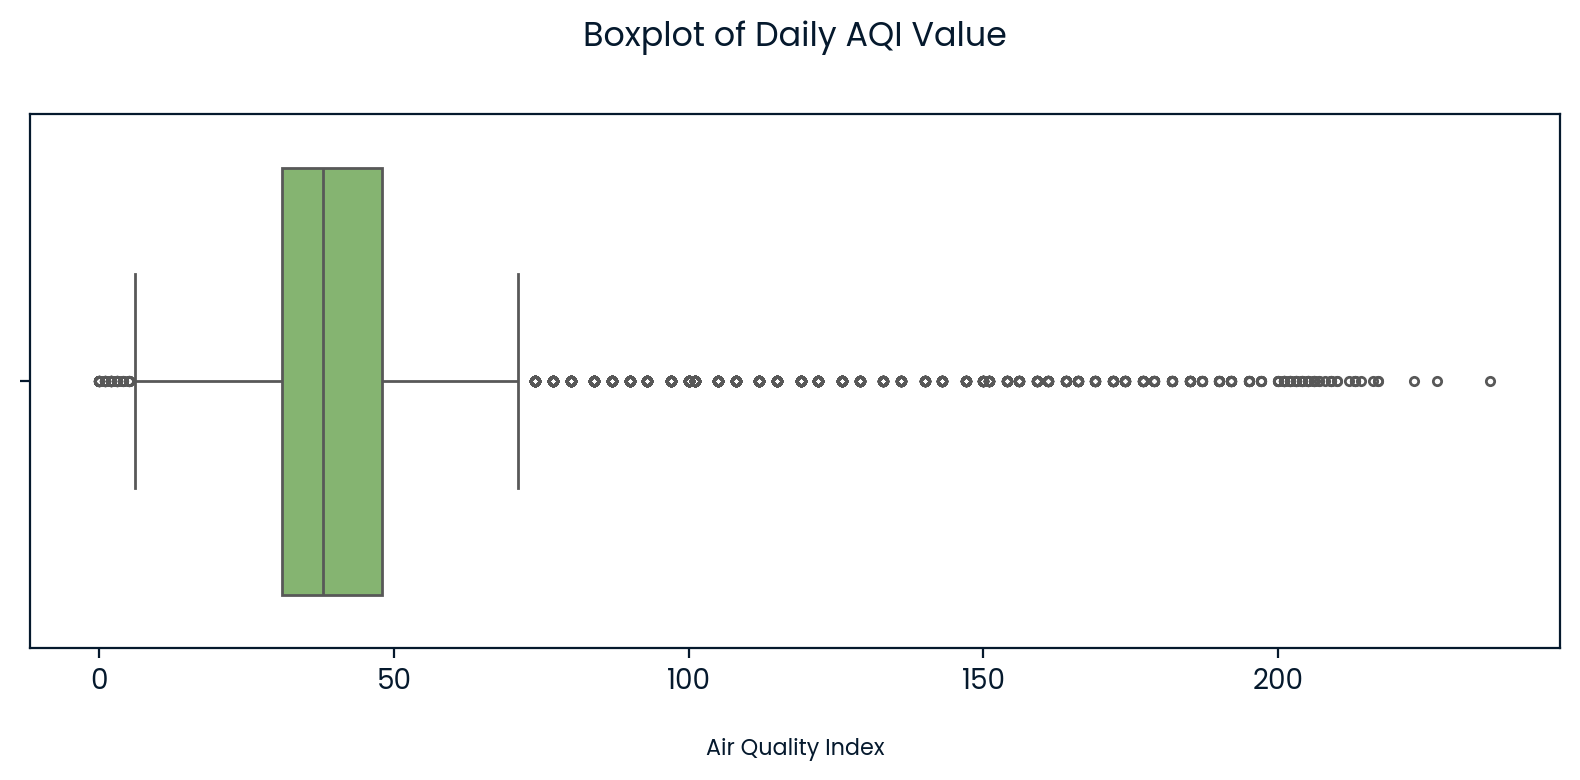

In [109]:
# Boxplot for Daily AQI Value 
plt.figure(figsize=(8, 4))
sns.boxplot(
    x=df['Daily AQI Value'],
    palette='summer',
    flierprops=dict(markersize=3),    
)
plt.title("Boxplot of Daily AQI Value", pad=25)
plt.xlabel("Air Quality Index", fontsize=8, labelpad=15)
plt.tight_layout()
plt.show()

In [110]:
# Calculate outlier bounds using IQR 

Q1 = df['Daily AQI Value'].quantile(0.25)
Q3 = df['Daily AQI Value'].quantile(0.75)

# Calculate IQR
IQR = Q3 - Q1

# Calculate bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"Q1 = {Q1:.3f} | Q3 = {Q3:.3f} | IQR = {IQR:.3f}")
print(f"\nLower bound: {lower_bound:.3f}")
print(f"Upper bound: {upper_bound:.3f}")

# Identify outliers
outliers = df[
    (df['Daily AQI Value'] < lower_bound) | (df['Daily AQI Value'] > upper_bound)
]

print(f"\nNumber of outliers: {len(outliers)}")

Q1 = 31.000 | Q3 = 48.000 | IQR = 17.000

Lower bound: 5.500
Upper bound: 73.500

Number of outliers: 5992


We found 1232 and 5992 outliers for ozone concentration and AQI value respectively. Our first instinct was to drop or impute these outliers. However, our approach in this investigation was always to preserve data whenever possible. So we decided to understand the data from a scientific perspective. 

Reviewing our earlier summary statistics, we observed that the values for `Daily Max 8-hour Ozone Concentration` ranged from 0 to 0.139 ppm, while the `Daily AQI Value` ranged from 0 to 236.

For ground-level ozone, the EPA defines 0.07 ppm average over an 8-hour period as the safe threshold. Readings above this level are rare but possible, especially during extreme events. Values far beyond this—such as 2.5 ppm—would be suspect and likely due to data entry errors. As for the AQI Value, a reading up to 50 represents good air quality, while a value above 300 is hazardous. 

In our case, the outliers were high, but they fell within the realm of possibility. So we decided to keep these records in the dataset. 

### 2.3.2 The `Daily Obs Count` Column

An anomaly was found in the `Daily Obs Count` column. Some readings had as  many as 1,000 observations in a single day, which is far above what any monitoring station could actually collect. 

In [111]:
# The highest number of observations in the data
print(df['Daily Obs Count'].value_counts().sort_index(ascending=False).head())


Daily Obs Count
1000     542
24      5834
23        34
22        46
21        50
Name: count, dtype: int64


Upon closer inspection, we found this field was proportional to the `Percent Complete` column. Theoretically, we could have adjusted these outliers, either by capping them at 24 (the maximum hours in a day) or by deriving more accurate values using the `Percent Complete`. In the end, we opted not to handle this error. The field `Daily Obs Count` not central to our analysis, and did not affect data in our other columns.

## 2.4 Missing Values

### 2.4.1 Filling in the `Date Parsed` Column

With outliers addressed, the next challenge was dealing with missing values—especially in the Date column. Since a complete and accurate timeline was central to our analysis, the team made it a priority to reconstruct dates wherever possible.

To do this, we set out to fill in missing dates using a step-by-step approach:
1. If dates were missing at the start of a site’s records, we filled backwards from the first known date. We counted back one day at a time but stopped at January 1st, 2024. No dates earlier than this were assigned.
2. For gaps in the middle of a site’s timeline, we filled forward by adding one day at a time to the last known date. If this process would have resulted in dates after December 31st, 2024, we converted or left those entries as `null` values.
3. Any sequence that broke the expected order—for example, a January date appearing after December at the same site—was marked as invalid and set to missing.

We captured this logic in a custome `fill_dates_sequential_max` function, which processes each site’s records one by one, reconstructs any missing dates using the above rules, and ensures that all site timelines are bounded within the 2024 calendar year.

In [112]:
def fill_dates_sequential(df, site_col='Site ID', date_col='Date Parsed'):
    
    # Fills missing dates for each site using a logical sequence, with all dates clamped to Jan 1, 2024 and Dec 31, 2024.
    min_date = pd.Timestamp('2024-01-01')
    max_date = pd.Timestamp('2024-12-31')
    filled = []

    # Process records site by site
    for site, group in df.groupby(site_col, sort=False):
        group = group.copy()
        dates = group[date_col].tolist()
        new_dates = []
        valid_idx = [i for i, d in enumerate(dates) if pd.notnull(d)]

        # Skip sites with no valid dates
        if not valid_idx:
            filled.append(group)
            continue
        first_valid, last_valid = valid_idx[0], valid_idx[-1]

        # Fill missing dates at the start, but not before Jan 1, 2024
        for i in range(first_valid):
            known = dates[first_valid]
            candidate = known - timedelta(days=(first_valid - i))
            if candidate < min_date:
                candidate = pd.NaT
            new_dates.append(candidate)

        curr = dates[first_valid]
        new_dates.append(curr)

        # Fill missing dates in the middle
        for i in range(first_valid+1, last_valid+1):
            if pd.notnull(dates[i]):
                curr = dates[i]
            else:
                next_date = curr + timedelta(days=1)
                if next_date > max_date:
                    next_date = pd.NaT
                curr = next_date
            new_dates.append(curr)

        # Any trailing dates left as missing
        for i in range(last_valid+1, len(dates)):
            new_dates.append(pd.NaT)

        # Ensure all dates stay within the allowed range
        group[date_col] = pd.to_datetime([
            d if (pd.isna(d) or (min_date <= d <= max_date)) else pd.NaT
            for d in new_dates
        ])
        filled.append(group)

    return pd.concat(filled, ignore_index=True)

# Create a new dataset called df_filled:
df_filled = fill_dates_sequential(df, site_col='Site ID', date_col='Date Parsed')

This method allowed us to restore most of the missing dates without disturbing the order of valid ones. 

In [113]:
print(pd.DataFrame({'BEFORE': df['Date Parsed'].head(), 'AFTER': df_filled['Date Parsed'].head()}))

      BEFORE      AFTER
0        NaT 2024-01-01
1 2024-01-02 2024-01-02
2        NaT 2024-01-03
3 2024-01-04 2024-01-04
4 2024-01-05 2024-01-05


After filling in, we verified that the data now covered every day of 2024 (366 unique dates represented). Despite these efforts, 118 dates remained missing—either because there was no logical way to fill the gap, or the data would have extended past the allowed range. 

In [114]:
print(f"Current number of rows of dataset: {len(df_filled)}")

print("\nDate range in df_filled:")
print("  Min date:", df_filled['Date Parsed'].min())
print("  Max date:", df_filled['Date Parsed'].max())

num_unique_dates = df_filled['Date Parsed'].nunique()
print("\nNumber of unique dates in df_filled:", num_unique_dates)

missing_dates = df_filled['Date Parsed'].isna().sum()
print("\nNumber of missing dates in df_filled:", missing_dates )

Current number of rows of dataset: 54424

Date range in df_filled:
  Min date: 2024-01-01 00:00:00
  Max date: 2024-12-31 00:00:00

Number of unique dates in df_filled: 366

Number of missing dates in df_filled: 118


We accepted that a few rows could not be 'saved' in the process of protecting the integrity of the timelines. With no further options, we dropped all records with null values in `Date Parsed` column. The size of the dataset after this exercise was **54, 306**.

In [115]:
# Drop all missing dates
df_filled = df_filled[df_filled['Date Parsed'].notnull()].reset_index(drop=True)
print("Rows after dropping null dates:", len(df_filled))

Rows after dropping null dates: 54306


### 2.4.2 Second Removal of Duplicates

The missing dates which we filled in earlier had re-introduced duplicates in the dataset, so we had to deal with this again. 

In [116]:
dupe_mask = df_filled.duplicated(subset=['Site ID', 'Date Parsed'], keep=False)
num_dupes = dupe_mask.sum()
print("Rows that are duplicated (including originals):", num_dupes)

Rows that are duplicated (including originals): 130


Using the same rule as before—a unique combination of site ID and date—we removed any remaining duplicate entries. In total, 65 rows were dropped and this left us with a final count of **54, 241** rows.

In [117]:
# Define important columns for scoring
important_cols = ['Daily Max 8-hour Ozone Concentration', 'Daily AQI Value', 'Method Code']

# Calculate missing values for important columns (lower is better)
df_filled['missing_count'] = df_filled[important_cols].isnull().sum(axis=1)

# Sort so the row with least missing data comes first in each group
df_filled.sort_values(['Site ID', 'Date Parsed', 'missing_count'], inplace=True)

# Drop duplicates, keeping the "best" (now first) row
df_filled.drop_duplicates(subset=['Site ID', 'Date Parsed'], keep='first', inplace=True)

# Clean up
df_filled.drop(columns=['missing_count'], inplace=True)
df_filled.reset_index(drop=True, inplace=True)

print(f"New length after second removal of duplicates: {len(df_filled)}")

New length after second removal of duplicates: 54241


At this stage, the team agreed that no further rows would be dropped. Any other missing values in the data would be handled by imputation.

### 2.4.3 Imputing `Daily Max 8-hour Ozone Concentration` and `Daily AQI` 

With the timeline complete and duplicates removed, the team identified the remaining columns with missing values that were key for analysis.

In [118]:
print("Rows missing Daily max:", df_filled['Daily Max 8-hour Ozone Concentration'].isnull().sum())
print("Rows with missing Daily AQI:", df_filled['Daily AQI Value'].isnull().sum())
print("Rows with missing Method Code:", df_filled['Method Code'].isnull().sum())

Rows missing Daily max: 2713
Rows with missing Daily AQI: 2708
Rows with missing Method Code: 6406


We began by researching the scientific relationship between the daily maximum ozone concentration and the AQI value. Using EPA standards, we found a formula that allowed us to impute one value when the other was present. 

In [119]:
# EPA Ozone 8-hour AQI breakpoints (2024 standard)
# Concentration in ppm
ozone_breaks = [
    (0.000, 0.054, 0, 50),
    (0.055, 0.070, 51, 100),
    (0.071, 0.085, 101, 150),
    (0.086, 0.105, 151, 200),
    (0.106, 0.200, 201, 300)
]

def ozone_to_aqi(ozone):
    for Clow, Chigh, Ilow, Ihigh in ozone_breaks:
        if Clow <= ozone <= Chigh:
            return ((Ihigh - Ilow) / (Chigh - Clow)) * (ozone - Clow) + Ilow
    return None  # Out of range

def aqi_to_ozone(aqi):
    for Clow, Chigh, Ilow, Ihigh in ozone_breaks:
        if Ilow <= aqi <= Ihigh:
            return ((aqi - Ilow) * (Chigh - Clow) / (Ihigh - Ilow)) + Clow
    return None

If a record was missing both the daily maximum and AQI value, we instead filled in the daily maximum using the monthly average for that particular site. Once that value was in place, we applied the EPA formula to estimate the missing AQI. This ensured that our imputations were grounded in real, site-specific trends rather than broad generalizations. 

To make this work, we first had to check that all 162 sites had at least one daily maximum reading that we could use as the monthly average.  

In [120]:
site_non_null_counts = (
    df_filled.groupby('Site ID')['Daily Max 8-hour Ozone Concentration']
    .apply(lambda x: x.notnull().sum())
    .reset_index(name='non_null_daily_max_count')
)

# Sites with no valid or null measurements 
sites_with_zero = site_non_null_counts[site_non_null_counts['non_null_daily_max_count'] == 0]

print(f"Sites with ZERO valid daily max readings: {sites_with_zero.shape[0]}")


Sites with ZERO valid daily max readings: 0


In code above, we found that every site had at least one daily reading, so we proceeded with the imputation

In [121]:
# First, extract month for easy grouping
df_filled['Month'] = df_filled['Date Parsed'].dt.month

# For fast lookup, create group means
site_month_mean = df_filled.groupby(['Site ID', 'Month'])['Daily Max 8-hour Ozone Concentration'].transform('mean')
site_mean = df_filled.groupby('Site ID')['Daily Max 8-hour Ozone Concentration'].transform('mean')

def fill_row(row):
    max_o = row['Daily Max 8-hour Ozone Concentration']
    aqi = row['Daily AQI Value']
    
    # If both missing, fill daily max with site-month mean, then AQI
    if pd.isnull(max_o) and pd.isnull(aqi):
        val = row['site_month_mean']
        if pd.isnull(val):
            val = row['site_mean']
        if pd.notnull(val):
            val = round(val, 3)
            row['Daily Max 8-hour Ozone Concentration'] = val
            row['Daily AQI Value'] = int(round(ozone_to_aqi(val)))
            
    # If max_o exists and AQI is missing, compute AQI
    elif pd.notnull(max_o) and pd.isnull(aqi):
        row['Daily Max 8-hour Ozone Concentration'] = round(max_o, 3)
        row['Daily AQI Value'] = int(round(ozone_to_aqi(max_o)))
        
    # If AQI exists and max_o is missing, estimate max_o
    elif pd.isnull(max_o) and pd.notnull(aqi):
        ozone_est = aqi_to_ozone(aqi)
        if pd.notnull(ozone_est):
            row['Daily Max 8-hour Ozone Concentration'] = round(ozone_est, 3)
        row['Daily AQI Value'] = int(round(aqi))
    else:
        # If both exist, still ensure correct rounding
        row['Daily Max 8-hour Ozone Concentration'] = round(max_o, 3)
        row['Daily AQI Value'] = int(round(aqi))
    return row

# Attach mean columns for use in row function
df_filled['site_month_mean'] = site_month_mean
df_filled['site_mean'] = site_mean

We can see the effects of the imputation using some sample rows

In [122]:
print("BEFORE\n")
print(df_filled.iloc[95:100][['Date Parsed', 'Site ID', 'Daily Max 8-hour Ozone Concentration', 'Daily AQI Value']])

BEFORE

   Date Parsed   Site ID  Daily Max 8-hour Ozone Concentration  Daily AQI Value
95  2024-03-11  60010009                                 0.039             36.0
96  2024-03-12  60010009                                 0.034              NaN
97  2024-03-13  60010009                                   NaN              NaN
98  2024-03-14  60010009                                 0.039             36.0
99  2024-03-15  60010009                                 0.038             35.0


In [123]:
# Apply function row-wise to the dataset
df_filled = df_filled.apply(fill_row, axis=1)

# Clean up helper columns
df_filled.drop(columns=['Month', 'site_month_mean', 'site_mean'], inplace=True)


Checking the same sample rows again, we can see the missing values were logically filled in

In [124]:
print("AFTER\n")

print(df_filled.iloc[95:100][['Date Parsed', 'Site ID', 'Daily Max 8-hour Ozone Concentration', 'Daily AQI Value']])

AFTER

   Date Parsed   Site ID  Daily Max 8-hour Ozone Concentration  Daily AQI Value
95  2024-03-11  60010009                                 0.039               36
96  2024-03-12  60010009                                 0.034               31
97  2024-03-13  60010009                                 0.037               34
98  2024-03-14  60010009                                 0.039               36
99  2024-03-15  60010009                                 0.038               35


### 2.4.4 Imputing `Method Code`

For imputation of the `Method Code`, our focus was on consistency. We filled missing values with the most common method code used at that particular site. However, we discovered 3 sites did not have any method code

In [126]:
site_non_null_counts = (
    df_filled.groupby('Site ID')['Method Code']
    .apply(lambda x: x.notnull().sum())
    .reset_index(name='non_null_method_code_count')
)

# Sites with ZERO valid measurements 
sites_with_zero = site_non_null_counts[site_non_null_counts['non_null_method_code_count'] == 0]

print(f"Sites with ZERO valid method code: {sites_with_zero.shape[0]}")

Sites with ZERO valid method code: 3


In the case where a site had no recorded method code, we used the overall most common method found in the dataset.

The team acknowledged that making these types of estimates across thousands of records can affect the anlysis. However, given the nature of our data and the need for a complete evidence file, we judged that the risk was acceptable. Every step taken was designed to keep the analysis as accurate as possible without discarding valuable information.

In [127]:
# Map: get the mode for each site
mode_map = df_filled.groupby('Site ID')['Method Code'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
df_filled['Method Code'] = df_filled['Method Code'].fillna(df_filled['Site ID'].map(mode_map))

# Fill by each site's mode (your previous method)
mode_per_site = df_filled.groupby('Site ID')['Method Code'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
def fill_row(row):
    if pd.isna(row['Method Code']):
        return mode_per_site[row['Site ID']]
    return row['Method Code']
    
df_filled['Method Code'] = df_filled.apply(fill_row, axis=1)

# For any values still missing, fill with global mode
global_mode = df_filled['Method Code'].mode()
if not global_mode.empty:
    df_filled['Method Code'] = df_filled['Method Code'].fillna(global_mode.iloc[0])

After completing this process, the dataset was as complete as it could be. We had a total of **54, 241** rows and the evidence was now ready for the final phase of the investigation: analysis and interpretation.

In [128]:
print(f"Rows in clean dataset: {len(df_filled)}")

clean_profile = pd.DataFrame({
    "Data Type":df_filled.dtypes,
    "Missing Count":df_filled.isna().sum(),
    "Missing %": (df_filled.isnull().mean() * 100).round(2),
    "Unique Count": df_filled.nunique()
})

clean_profile

Rows in clean dataset: 54241


,Data Type,Missing Count,Missing %,Unique Count
Date,object,0,0.00,733
Source,object,0,0.00,2
Site ID,int64,0,0.00,162
POC,int64,0,0.00,2
Daily Max 8-hour Ozone Concentration,float64,0,0.00,124
Units,object,0,0.00,1
Daily AQI Value,int64,0,0.00,124
Local Site Name,object,0,0.00,162
Daily Obs Count,int64,0,0.00,24
Percent Complete,float64,0,0.00,23


The last step oft he cleaning stage was to keep only the fields essential for analysis. The team selected columns that would support all future investigative work and unnecessary fields were set aside. We then standardized the column names for clarity and consistency with the original EPA dataset.

In [129]:
# Define the essential columns to keep for analysis
columns_to_keep = [
    'Date Parsed',
    'Daily Max 8-hour Ozone Concentration',
    'Daily AQI Value',
    'County Parsed',
    'Site ID',
    'Local Site Name',
    'Source',
    'Method Code',
    'Site Latitude',
    'Site Longitude'
]

# Subset the DataFrame
data = df_filled[columns_to_keep].copy()

# Rename columns
data.rename(columns={
    'Date Parsed': 'Date',
    'County Parsed': 'County'
}, inplace=True)


# 🧪 3. Data Analysis

The following section presents the results of our analysis on ozone data in California for the year 2024.

**NOTE: Most code blocks have been hidden to improve readability and highlight key findings.**

## Q1. How does daily maximum 8-hour ozone concentration vary over time and regions?

Our first task was to spot the changes of ozone levels across time and space. To answer this, we had to decide how to define both “time” and “region”. 

For region, counties made the most sense. By grouping data at the county level, we could see true regional trends instead of getting distracted by noise from individual sites.

For time, we chose to use weeks. Analyzing by day would have exposed too many gaps and made it hard to see bigger trends. Months were too broad and would have hidden important changes. Weeks would allow us to track ozone levels without losing detail.

We needed a way to quickly spot changes across both counties and time. The team selected a heatmap for this task so we could survey the entire state at a glance.

In [130]:
# Extract the start date for each week from the 'Date' column
data['Week'] = data['Date'].dt.to_period('W').apply(lambda r: r.start_time)

# Calculate the mean ozone concentration by week and county
weekly_ozone = (data.groupby(['Week', 'County'])['Daily Max 8-hour Ozone Concentration'].mean().reset_index())

# Get a sorted list of all unique weeks
unique_weeks = sorted(weekly_ozone['Week'].unique())

# Map each unique week start date to a consecutive integer for labeling
week_mapping = {week: i+1 for i, week in enumerate(unique_weeks)}

# Add a numeric 'Week_Number' column for easier plotting
weekly_ozone['Week_Number'] = weekly_ozone['Week'].map(week_mapping)

# Reshape the data to have counties as rows and weeks as columns 
heatmap_data = weekly_ozone.pivot(index='County', columns='Week_Number', values='Daily Max 8-hour Ozone Concentration')

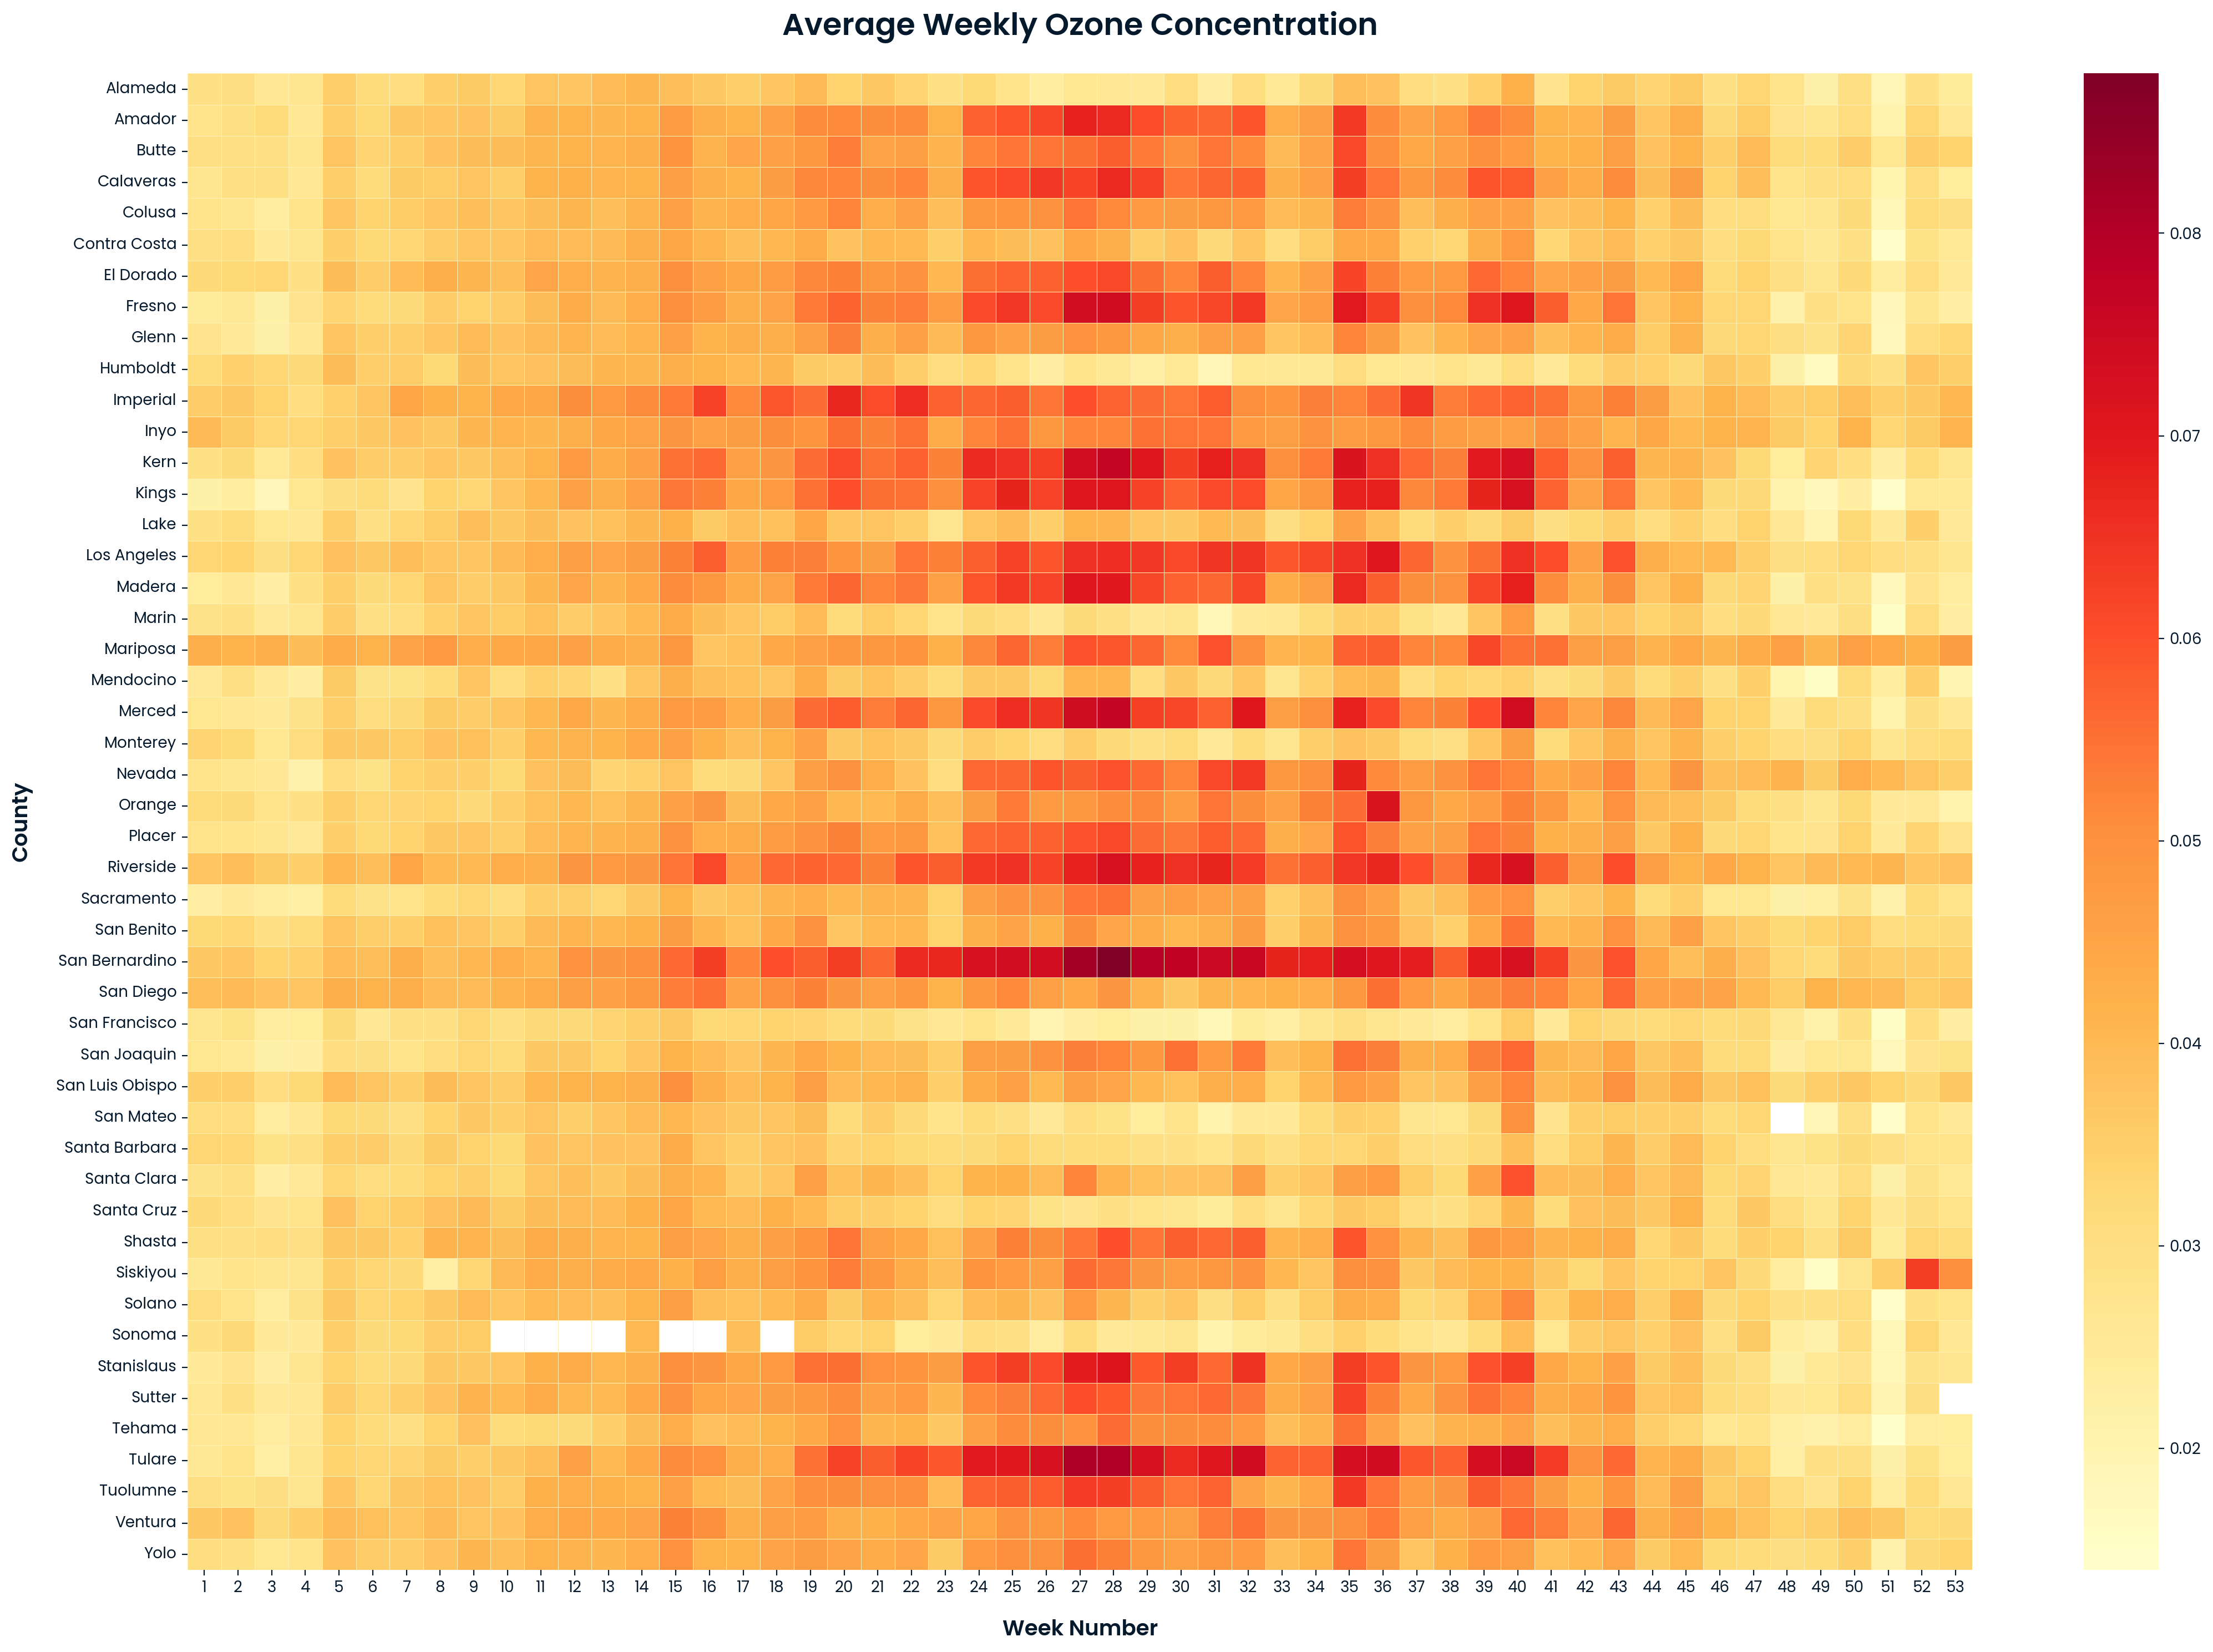

In [131]:
plt.figure(figsize=(22, 15))
sns.heatmap(heatmap_data, cmap='YlOrRd', linewidths=0.3, linecolor='#FFF0B3')
plt.title('Average Weekly Ozone Concentration', pad=25, fontsize=20, fontweight='semibold')
plt.xlabel('Week Number', fontsize=14, fontweight='semibold', labelpad=15)
plt.ylabel('County', fontsize=14, fontweight='semibold', labelpad=15)
plt.tight_layout()
plt.show()

The first pass over the heatmap revealed a few things right away. Some counties, especially **Sonoma**, had missing data for several weeks. To confirm this was not a display error, we checked record counts for each county which revealed Sonoma had the fewest records in the dataset. This eased any fears we had about errors on our heatmap.

In [132]:
# Count the total number of daily max ozone values per county
county_record_counts = (
    data.groupby('County')['Daily Max 8-hour Ozone Concentration']
    .count()
    .reset_index()
    .rename(columns={'Daily Max 8-hour Ozone Concentration': 'Num Records'})
    .sort_values('Num Records', ascending=True)
)

print(county_record_counts.head())

           County  Num Records
40         Sonoma          275
9        Humboldt          342
33      San Mateo          344
30  San Francisco          344
3       Calaveras          345


#### i) Key Trends Over Time 

**Seasonality**:
In terms of general trends across the entire state, there was a clear pattern. Ozone concentrations were at their lowest during the winter, covering roughly weeks 1 to 8 and again from week 49 to the end of the year. 

As summer approached, levels rose across almost most counties.This lines up with the general  understanding that ozone builds up faster when there is more heat and sunlight.

**Peak Period**:
The most intense ozone levels (the darkest cells) are generally concentrated between weeks 24 and 35 during the summer.



#### ii) Regional Patterns 
Counties like **San Bernardino**, **Los Angeles**, **Riverside**, and **Tulare** consistently show darker colors, indicating higher average ozone concentrations especially during the summer.

Although most counties had high ozone during the summer, not every region behaved the same way. A few places, like **Alameda**, **Humboldt**, and **San Francisco**, had low ozone concentrations all year, and some even seemed to have their lowest readings during the summer, which went against the statewide trend.

## Q2. a) Are there any areas that consistently show high ozone concentrations? 

Our team kept the analysis at the weekly and county level by using the `weekly_ozone` dataframe from the previous question which contained the mean ozone concentration by week and county 

For every county, we identified the lowest and highest of these weekly averages. These numbers show the weeks with the cleanest and worst ozone conditions in each county. We then compared this to the EPA’s 0.070 ppm safety standard. 

We decided to use a simple bar chart. Counties with complete data for all 53 weeks are shown in green and those with missing weekly are displayed in gray. This makes it clear which results can be trusted and which should be treated with caution because missing data can hide or exaggerate seasonal peaks.

In [133]:
# Calculate min, max, and number of weeks per county
county_range = (
    # We get weekly ozone (avg weekly reading) from previous question
    weekly_ozone.groupby('County')['Daily Max 8-hour Ozone Concentration']
    .agg(['min', 'max', 'count'])
    .reset_index()
    .rename(columns={'min': 'Min Weekly Ozone', 'max': 'Max Weekly Ozone', 'count': 'Num Weeks'})
    .sort_values('Min Weekly Ozone', ascending=False)
)

# Add a flag for completeness
county_range['Complete Data'] = county_range['Num Weeks'] == 53


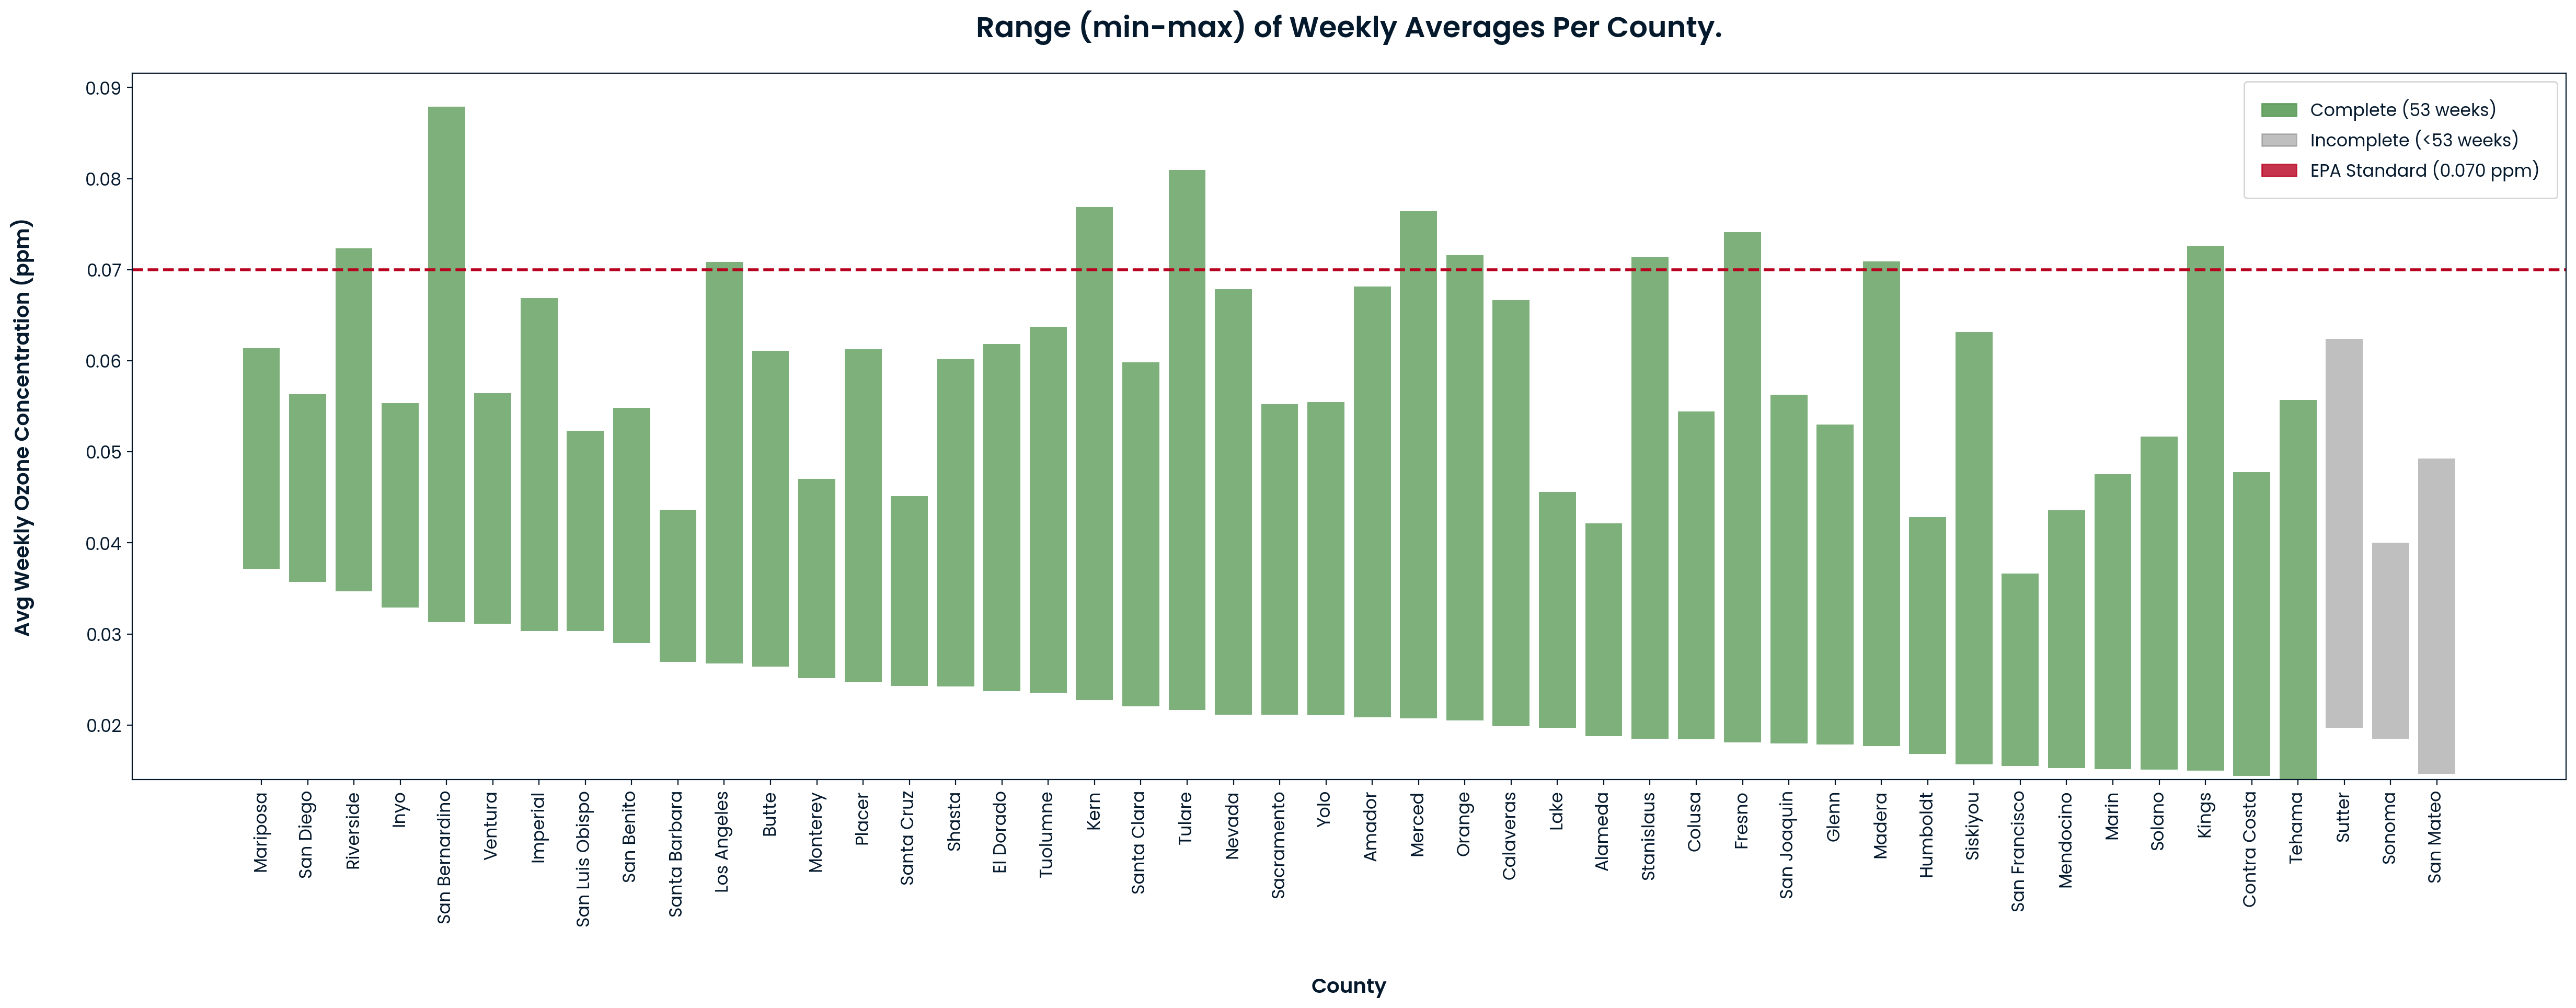

In [134]:
plt.figure(figsize=(25, 10))

# Plot for counties with complete data
for idx, row in county_range[county_range['Complete Data']].iterrows():
    plt.bar(
        row['County'],
        row['Max Weekly Ozone'] - row['Min Weekly Ozone'],
        bottom=row['Min Weekly Ozone'],
        color='#5D9C59',
        alpha=0.8,
    )

# Plot for counties with incomplete data (faded/gray)
for idx, row in county_range[~county_range['Complete Data']].iterrows():
    plt.bar(row['County'],row['Max Weekly Ozone'] - row['Min Weekly Ozone'],bottom=row['Min Weekly Ozone'],color='gray',alpha=0.5)

# Add EPA 8-hour ozone standard line
plt.axhline(0.070, color='#B8001F', linestyle='--', linewidth=2, label='EPA Standard (0.070 ppm)')

orange_patch = mpatches.Patch(color='#5D9C59', label='Complete (53 weeks)', alpha=0.9)
gray_patch = mpatches.Patch(color='gray', label='Incomplete (<53 weeks)', alpha=0.5)
red_line = mpatches.Patch(color='#B8001F', label='EPA Standard (0.070 ppm)', alpha=0.8)

plt.title('Range (min-max) of Weekly Averages Per County.', pad=25, fontsize=20, fontweight='semibold')
plt.xticks(rotation=90, fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('Avg Weekly Ozone Concentration (ppm)', fontweight='semibold', fontsize=14, labelpad=35)
plt.xlabel('County', fontweight='semibold', fontsize=14, labelpad=35)
plt.legend(handles=[orange_patch, gray_patch, red_line], loc='upper right', fontsize=12, frameon=True, borderpad=1)
plt.tight_layout(pad=2)
plt.show()


No county had ozone concentrations above the EPA standard for every single week of the year. However, **Riverside** and **San Bernardino** stand out because their minimum reaadings are among the highest in the state, and their maximums are well above the standard. This suggests that these counties experience elevated ozone pollution much more frequently than others, with only brief periods of low concentrations.

## b) Do different methods report different ozone levels?

To understand whether different measurement methods produced different ozone readings, the team used boxplots to compare the spread, median, and outliers for each method.

This visual comparison revealed that three of the methods had similar median ozone concentrations. Method 53, however, stood out with a higher median, as well as generally higher readings. This raised the question of whether Method 53 was truly reporting higher ozone values or if there was another reason behind this pattern.

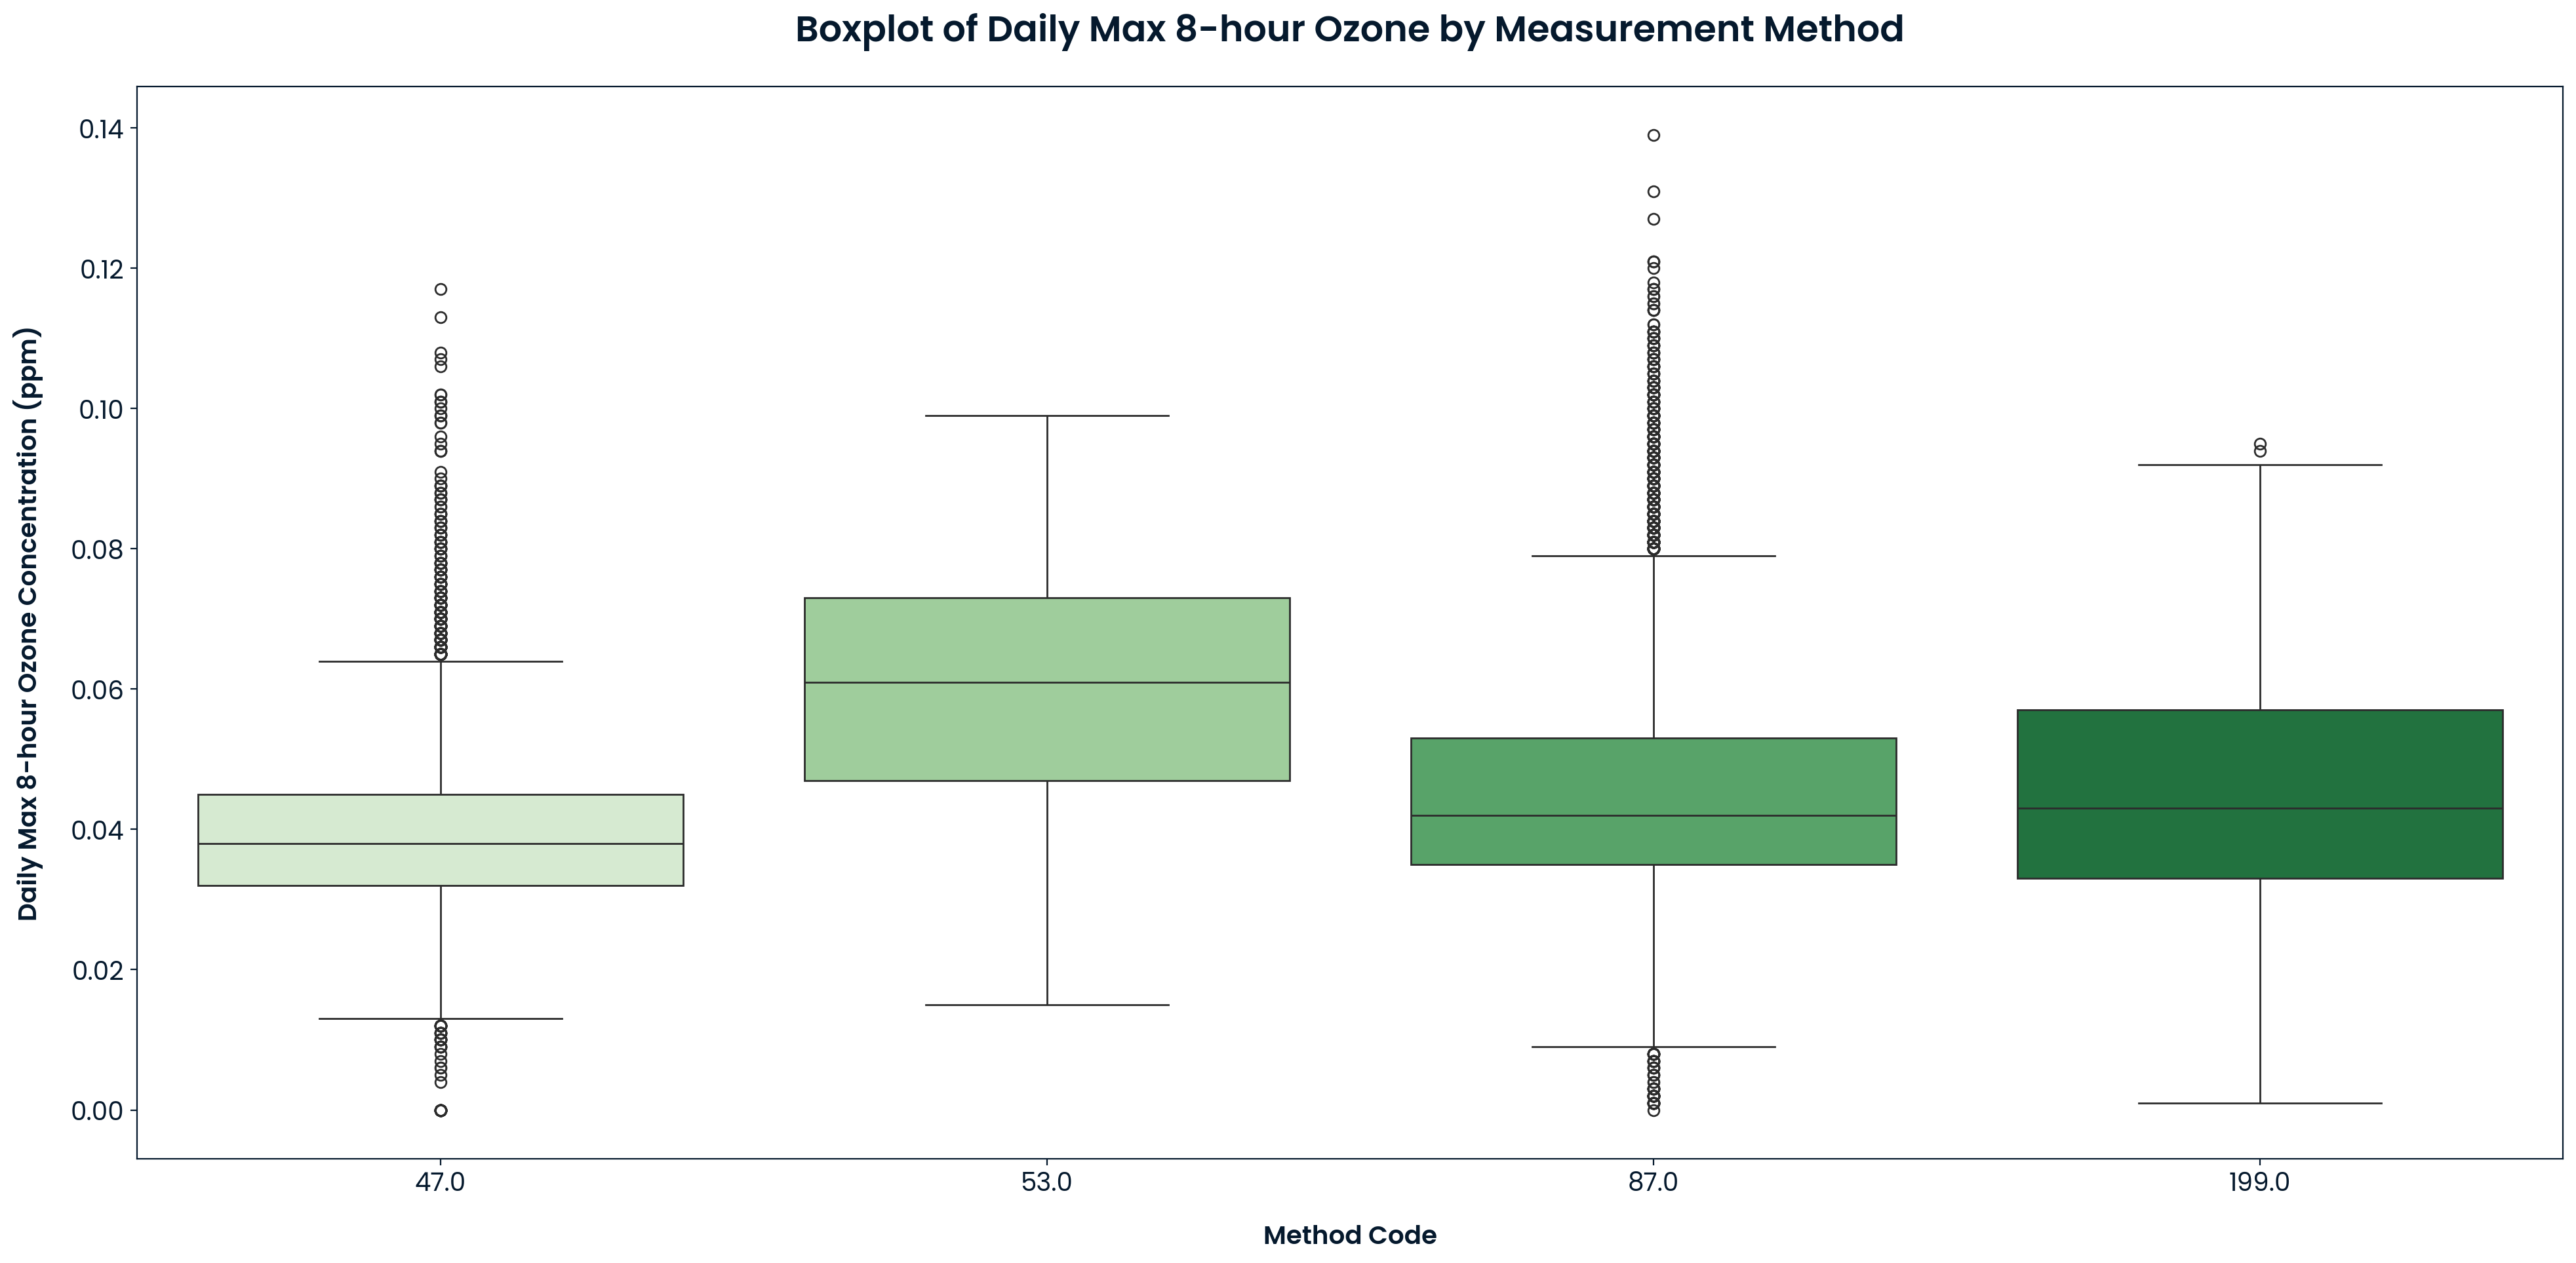

In [135]:
plt.figure(figsize=(20, 10))

sns.boxplot(data=data, x='Method Code', y='Daily Max 8-hour Ozone Concentration', showfliers=True,  palette='Greens')

plt.title('Boxplot of Daily Max 8-hour Ozone by Measurement Method', pad=25, fontsize=20, fontweight='semibold')
plt.xlabel('Method Code', fontweight='semibold', fontsize=14, labelpad=15)
plt.ylabel('Daily Max 8-hour Ozone Concentration (ppm)', fontweight='semibold', fontsize=14, labelpad=15)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout(pad=2)
plt.show()

After seeing the boxplot result, our first instinct was to conclude that different methods report different ozone levels. But when we looked back, we noticed something unusual. Methods 47 and 87 showed a large number of outliers, while the other two methods barely had any. This raised new questions about why outliers were concentrated in just two methods.

To investigate further, we looked at the summary statistics for each method. This revealed that methods 47 and 87 had way more daily records than the others. A higher number of records makes it more likely to see extreme values, which explains the outliers.

In [136]:
method_stats = data.groupby('Method Code')['Daily Max 8-hour Ozone Concentration'].agg(['count', 'mean', 'median', 'std'])

print(method_stats)

             count      mean  median       std
Method Code                                   
47.0         12763  0.039252   0.038  0.011724
53.0           479  0.059764   0.061  0.016913
87.0         36711  0.044658   0.042  0.014891
199.0         4288  0.044851   0.043  0.016337


We also checked how many monitoring sites used each method. Method 53 was only used at two sites while the other three methods were used at many more locations. This meant that the higher ozone readings reported by method 53 were likely due to conditions at those two specific sites, not the measurement method itself.

In [137]:
# Unique Site IDs per Method Code
method_site_counts = (
    data.groupby('Method Code')['Local Site Name']
    .nunique()
    .reset_index()
    .rename(columns={'Local Site Name': 'Num Unique Sites'})
    .sort_values('Num Unique Sites', ascending=False)
)
print(method_site_counts)


   Method Code  Num Unique Sites
2         87.0               109
0         47.0                42
3        199.0                12
1         53.0                 2


After reviewing the evidence, the team concluded that while there are real differences in ozone readings by measurement method, most of these can be traced back to where the methods were used and how many records they produced. The choice of site and the number of readings collected appear to have a bigger impact than the method alone. Therefore there is **no conclusive evidence** that any measurement method, by itself, consistently reported higher or lower ozone levels.

## Q3. Consider if urban activity (weekend vs. weekday) has any effect on ozone levels across different days.

The next step in our investigation was to see if ozone levels across California changed depending on the day of the week. In this case, we interpreted “urban activity” to mean the difference between weekdays, when commuting, traffic and industrial activities are usually at their highest, and weekends, when these patterns change.

We started by dividing each date in the dataset into two categories. Days from Monday to Friday were classified as weekdays, while Saturday and Sunday were counted as weekends. Then we compared the daily maximum 8-hour ozone concentrations between these two groups for the entire state.

In [138]:
data['Day Type'] = data['Date'].dt.dayofweek.apply(lambda x: 'Weekend' if x >= 5 else 'Weekday')

Before moving forward, we checked to make sure our data was balanced. In 2024, there were 262 weekays and 104 weekend days. This means there were about 2.52 times as many weekdays as weekends. Our cleaned data showed a ratio close to this, which meant our comparisons were on solid ground.

In [139]:
# Count the number of records by day type
counts = data['Day Type'].value_counts().reset_index()
counts.columns = ['Day Type', 'count']
print(counts)

# Calculate the weekday:weekend ratio
weekday_count = counts[counts['Day Type'] == 'Weekday']['count'].values[0]
weekend_count = counts[counts['Day Type'] == 'Weekend']['count'].values[0]
ratio = weekday_count / weekend_count
print(f"\nWeekday:Weekend ratio = {ratio:.2f}")

  Day Type  count
0  Weekday  38662
1  Weekend  15579

Weekday:Weekend ratio = 2.48


We visualized the distributions using a boxplot, which showed that ozone levels for weekdays and weekends almost completely overlapped. The medians were nearly identical, and both the range of values and the number of outliers were very similar between the two groups.

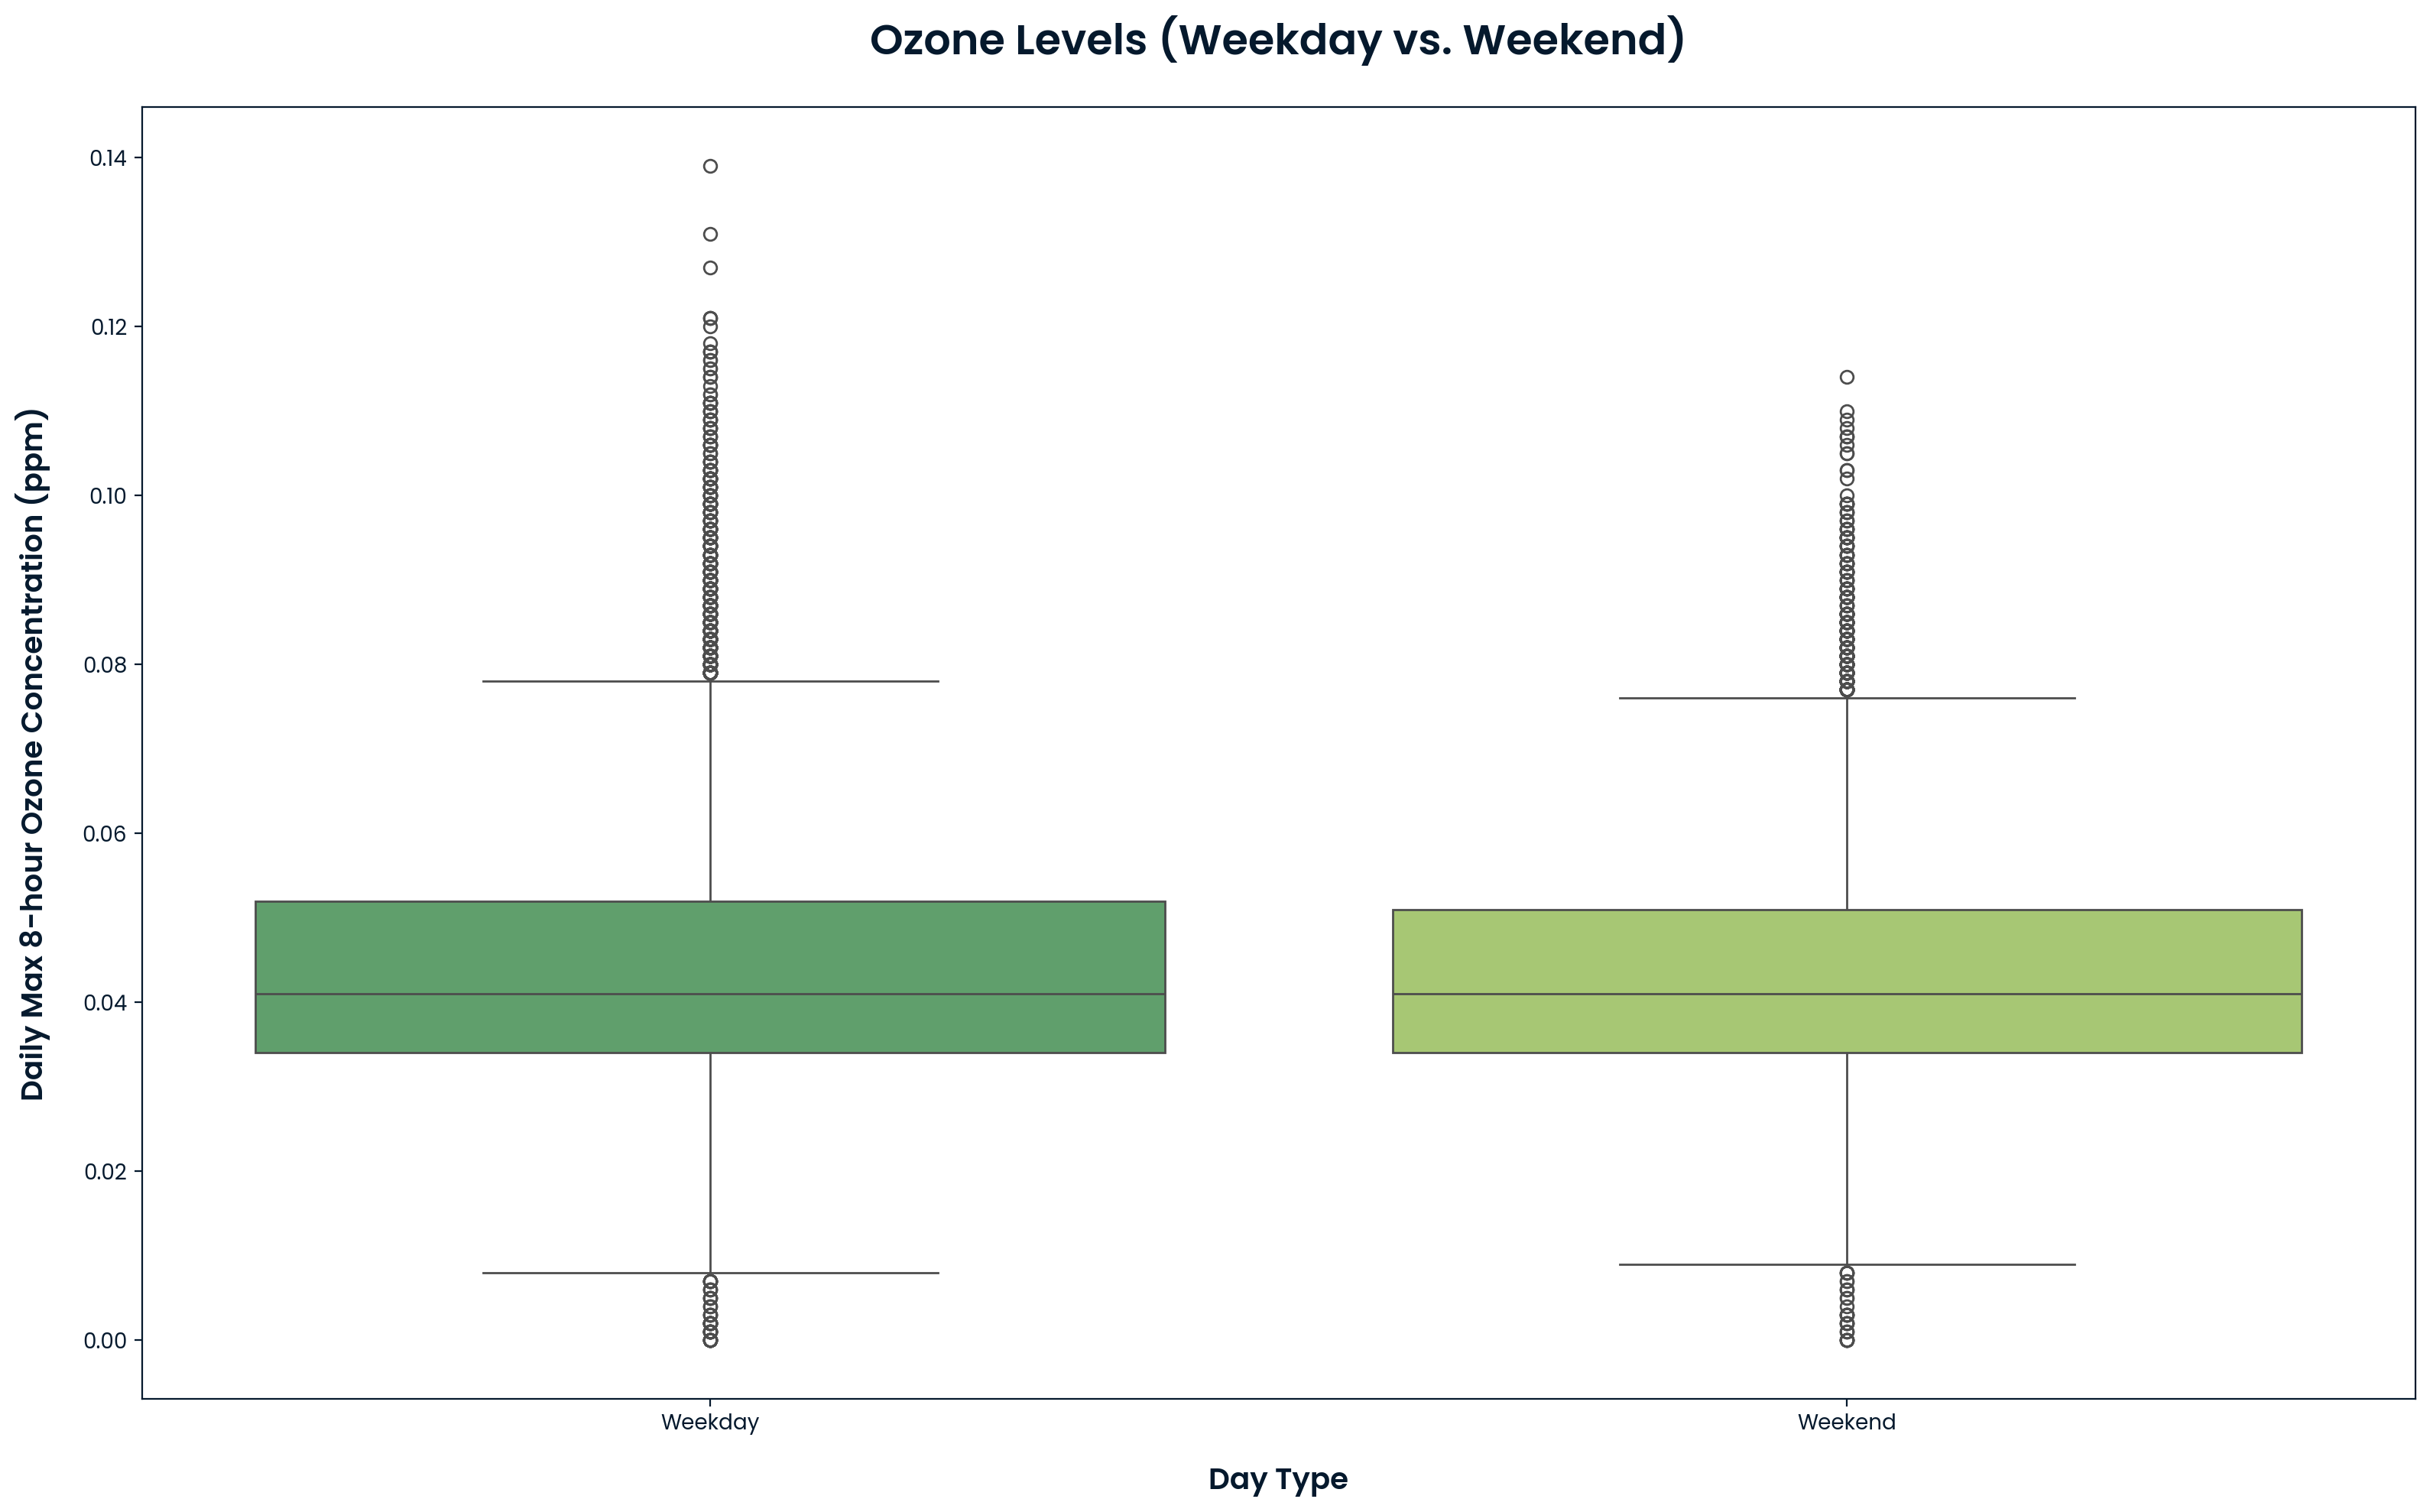

In [140]:
plt.figure(figsize=(16, 10))
sns.boxplot(
    data=data,
    x='Day Type',
    y='Daily Max 8-hour Ozone Concentration',
    palette='summer'
)

plt.title('Ozone Levels (Weekday vs. Weekend)', pad=25, fontsize=20, fontweight='semibold')
plt.xlabel('Day Type', fontweight='semibold', fontsize=14, labelpad=15)
plt.ylabel('Daily Max 8-hour Ozone Concentration (ppm)', fontweight='semibold', fontsize=14, labelpad=15)
plt.tight_layout()
plt.show()


To check for any subtle differences that might not be visible in the boxplot, we used the Mann-Whitney U test. This statistical test is appropriate for comparing two groups that may not follow a normal distribution, and it does not require equal sample sizes.

- **Null hypothesis (H₀)**: The distribution of ozone levels is the same on weekdays and weekends (i.e., there is no difference in the medians of the two groups).

- **Alternative hypothesis (H₁)**: The distribution of ozone levels is different between weekdays and weekends (i.e., there is a difference in the medians between the two groups).

The p-value from the test was **0.59** i.e p ≥ 0.05, so we fail to reject the null hypothesis. Therefore, there is no statistically significant difference in ozone levels between weekdays and weekends.

In [141]:
weekdays = data[data['Day Type'] == 'Weekday']['Daily Max 8-hour Ozone Concentration']
weekends = data[data['Day Type'] == 'Weekend']['Daily Max 8-hour Ozone Concentration']

stat, p = mannwhitneyu(weekdays, weekends, alternative='two-sided')
print(f"Mann-Whitney U-statistic: {stat:.2f}, p-value: {p:.4f}")

Mann-Whitney U-statistic: 302034858.50, p-value: 0.5949


We later calculated summary statistics for both groups and found that their medians were the same. The means and standard deviations were also very similar.

In [142]:
# Group by Day Type and calculate mean and median
ozone_by_daytype = (
    data.groupby('Day Type')['Daily Max 8-hour Ozone Concentration']
    .agg(['mean', 'median', 'std'])
    .reset_index()
)

print(ozone_by_daytype)

  Day Type      mean  median       std
0  Weekday  0.043639   0.041  0.014847
1  Weekend  0.043276   0.041  0.014029


Our findings conclusively showed that urban activity, as reflected by the day of the week, **does not** have a measurable impact on ozone concentrations across California.

## Q4. Bonus: plot a geospatial heatmap showing any high ozone concentrations.

To gain a better perspective on ozone pollutions across regions, the team conducted a geospatial analysis.

First, Each monitoring site was weighted by the number of days in 2024 when ozone levels exceeded the EPA standard of 0.070 ppm. We only considered sites that had at least one day of the year exceeding the safety standard. This gave us a clear picture of where high ozone events were most frequent.

In [143]:
# Define the threshold
ozone_threshold = 0.070

# Group by location and count days above threshold
site_exceedances_full = (
    data[data['Daily Max 8-hour Ozone Concentration'] > ozone_threshold]
        .groupby(['Local Site Name', 'County', 'Site Latitude', 'Site Longitude'])
        .agg(Num_Exceedance_Days=('Date', 'count'))
        .reset_index()
)

The result from the geospartial heatmap pointed to a strong concentration of high ozone days in Southern California and parts of the central region. In the north, high ozone days did occur, but they were less intense than those in the south. 

In [144]:
# Assume site_exceedances_full is as before

heat_data = [
    [row['Site Latitude'], row['Site Longitude'], row['Num_Exceedance_Days']]
    for idx, row in site_exceedances_full.iterrows()
    if row['Num_Exceedance_Days'] > 0  # Only sites with exceedances
]

# Center the map on California
m = folium.Map(location=[36.7783, -119.4179], zoom_start=6, tiles='Cartodb Positron')

# Add the heatmap
HeatMap(heat_data,
        radius=18,      # Increase for more blending, decrease for more “local” peaks
        blur=13,        # Controls smoothness
        max_zoom=11,    
        min_opacity=0.6 
).add_to(m)

m.save('ozone_heatmap.html')
m


The heatmap gave us a good overview of ozone activity acroos the states but we also thought it should be good to look at the geographic distribution of the actual sites. So we created a second map showing each monitoring site as a colored dot. Dots were colored green (lowest), yellow, orange or red (highest) to indicate increasing level of ozone concentration. Clicking a dot revealed details about the site, including the local name, county and the number of high ozone days recorded.

This second map allowed us to get closer to the facts. By shifting from a statewide heatmap to a site-by-site view, we could see exactly where the trouble was concentrated. Nearly all of medium-high ozone sites were found inland and away from the coast. These sites were also located along a corridor running from the Central region down into Southern California. One thing that also stood out was that sites with highest counts formed a distinct cluster in the south. These sites were mostly located in the San bernardino, Riverside and Los Angeles counties.

In [145]:
# Initialize map centered on California
dot_map = folium.Map(location=[36.7783, -119.4179], zoom_start=6, tiles='Cartodb Positron')

# Function to pick color based on exceedance days
def get_color(n):
    if n > 75:
        return 'red'
    elif n > 50:
        return 'orange'
    elif n > 25:
        return 'yellow'
    elif n > 0:
        return 'green'

# Add each site as a colored circle marker with a popup
for idx, row in site_exceedances_full.iterrows():
    folium.CircleMarker(
        location=[row['Site Latitude'], row['Site Longitude']],
        radius=5,
        color='black',                # Outline
        weight=1.2,
        fill=True,
        fill_color=get_color(row['Num_Exceedance_Days']),
        fill_opacity=0.88,
        popup=(f"<b>Site:</b> {row['Local Site Name']}<br>"
               f"<b>County:</b> {row['County']}<br>"
               f"<b>High-Ozone Days:</b> {row['Num_Exceedance_Days']}")
    ).add_to(dot_map)

# Save and display
dot_map.save('ozone_dotmap.html')
dot_map


# 🏁 Conclusion

At the start of this case, the team was called to uncover the facts behind rising ozone pollution in California. The expectation was to find a pattern that could be linked to specific locations, times, or human activity. 

After a full review of the evidence, the data pointed to regular cycles (with the highest levels during the summer), and persistent hotspots centered in the southern part of the state. The results also showed that the method of measurement and the day of the week made little difference at the statewide level. 

Throughout the year, local air quality was shaped not only by routine activity but also by larger forces. The year 2024 brought over 8,000 wildfires to the state according to data from the California Department of Forestry and Fire Protection (Read more: https://www.fire.ca.gov/incidents/2024). While not the main focus of this investigation, these events likely influenced the ozone patterns we observed and added another layer to an already complex problem.

In closing, the investigation confirmed that ozone pollution remains a serious concern in California. And while targeted intervention remains essential in certain regions, broader efforts are needed to strengthen monitoring and prepare for the impacts of exceptional events like wildfires. Protecting air quality across the state will depend on a combination of focused action in high-risk areas and flexible strategies that can respond to changing conditions throughout the year.
